In [1]:
# plotly standard imports
import plotly.graph_objs as go
import chart_studio.plotly as py

# Cufflinks wrapper on plotly
import cufflinks

# Data science imports
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 30

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from plotly.offline import iplot, init_notebook_mode
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

# Set global theme
cufflinks.set_config_file(world_readable=True, theme='pearl')

# Backtesting

For understand quality of predictions need make backtesting of bot on testing dataset

**TODO: Create strategy which can trade best way based on real future data.
    Then add model which can predict more accurate future values**

In [2]:
from src.load_datasets import load_datasets

train, test = load_datasets()

test

timestamp         open     high           low    close    volume
1816296  1587559320000   6954.70000   6956.5   6954.600000   6956.5  0.336500
1816297  1587559380000   6956.20000   6957.6   6952.800000   6955.5  0.038800
1816298  1587559440000   6956.30000   6956.3   6955.779638   6956.0  0.300000
1816299  1587559500000   6956.10000   6957.5   6955.300000   6955.3  0.113594
1816300  1587559560000   6955.80000   6955.8   6955.300000   6955.3  0.016867
...                ...          ...      ...           ...      ...       ...
2270365  1615315800000  53725.00000  53727.0  53725.000000  53727.0  1.119537
2270366  1615315860000  53780.00000  53780.0  53779.000000  53779.0  0.010000
2270367  1615315920000  53814.00000  53828.0  53814.000000  53828.0  0.016450
2270368  1615315980000  53903.00000  53910.0  53902.000000  53910.0  0.012500
2270369  1615316040000  53930.36601  53958.0  53930.366010  53953.0  1.040000

[454074 rows x 6 columns]

In [3]:
test.index = pd.to_datetime(test.pop('timestamp'), unit='ms')

test

open     high           low    close    volume
timestamp                                                                 
2020-04-22 12:42:00   6954.70000   6956.5   6954.600000   6956.5  0.336500
2020-04-22 12:43:00   6956.20000   6957.6   6952.800000   6955.5  0.038800
2020-04-22 12:44:00   6956.30000   6956.3   6955.779638   6956.0  0.300000
2020-04-22 12:45:00   6956.10000   6957.5   6955.300000   6955.3  0.113594
2020-04-22 12:46:00   6955.80000   6955.8   6955.300000   6955.3  0.016867
...                          ...      ...           ...      ...       ...
2021-03-09 18:50:00  53725.00000  53727.0  53725.000000  53727.0  1.119537
2021-03-09 18:51:00  53780.00000  53780.0  53779.000000  53779.0  0.010000
2021-03-09 18:52:00  53814.00000  53828.0  53814.000000  53828.0  0.016450
2021-03-09 18:53:00  53903.00000  53910.0  53902.000000  53910.0  0.012500
2021-03-09 18:54:00  53930.36601  53958.0  53930.366010  53953.0  1.040000

[454074 rows x 5 columns]

In [4]:
test_hours = test[17::60]

test_hours

open          high      low         close     volume
timestamp                                                                   
2020-04-22 13:00:00   6965.0   6965.000000   6961.4   6964.700000   0.722130
2020-04-22 14:00:00   7075.9   7091.100000   7075.8   7086.800000  16.205788
2020-04-22 15:00:00   7107.3   7111.401519   7107.3   7111.401519   1.145662
2020-04-22 16:00:00   7125.1   7140.600000   7121.0   7121.000000  25.176988
2020-04-22 17:00:00   7134.9   7135.000000   7134.9   7134.900000   1.745161
...                      ...           ...      ...           ...        ...
2021-03-09 14:18:00  54524.0  54589.000000  54506.0  54588.000000   6.905504
2021-03-09 15:18:00  54467.0  54477.000000  54445.0  54445.000000   0.136019
2021-03-09 16:18:00  53993.0  54052.000000  53993.0  54030.000000   1.747403
2021-03-09 17:18:00  54216.0  54218.000000  54193.0  54217.762830   1.310505
2021-03-09 18:18:00  54072.0  54101.000000  54072.0  54101.000000   0.010000

[7568 rows x 5 columns]

In [5]:
test_hours.iplot(subplots=True)

In [6]:
initial_cash = 10000 # dollars

## Calculate potentialy profit

Basically we have increasing market, so even with bad strategy trader can generate profit

To understand is strategy good or bad, need calculate basic profit from just holding value

In [7]:
open_price = test['open'][0]
close_price = test['close'][-1]

print('Open %.2f and %.2f close price' % (open_price, close_price))

potential_profit = round((initial_cash / open_price) * close_price) - initial_cash

print('Potential profit after holding value:', potential_profit)

Open 6954.70 and 53953.00 close price
Potential profit after holding value: 67578


In [8]:
import backtrader as bt
import backtrader.feeds as btfeeds

# Pass it to the backtrader datafeed and add it to the cerebro
data = bt.feeds.PandasData(dataname=test[:500])

data

## Setup strategy

In [24]:
import tensorflow as tf
from src.libs import checkpoints
from src.model import build_model
from src.prepare_datasets import get_scaler, add_indicators

model = build_model()
model = checkpoints.load_weights(model)

scaler = get_scaler()

class TestStrategy(bt.Strategy):
    
    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
        
    def __init__(self):
        # Keep a reference to the lines in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None
        
        self.pbar = tqdm(total=len(test))
        # get atr and pass as ATR
    
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm
                    ))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm
                         ))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            if order.status == order.Canceled:
                self.log('Order is Canceled (by the user)')
            elif order.status == order.Margin:
                self.log('Order is Margin (not enough cash to execute the order)')
            else:
                self.log('Order is Rejected (by the broker)')

        self.order = None
        
    def notify_store(self, msg, *args, **kwargs):
        self.log('Notification from store: %s' % msg)
    
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))
    
    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close %.2f' % self.dataclose[0])
        self.pbar.update()
        
        lines_warmap = 150
        
        # Are enough time for clalculations
        if len(self) < lines_warmap:
            return

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return
        
        
        df = pd.DataFrame({
            'close': self.data.close.get(size=lines_warmap),
            'low': self.data.low.get(size=lines_warmap),
            'high': self.data.high.get(size=lines_warmap),
            'open': self.data.open.get(size=lines_warmap),
            'volume': self.data.volume.get(size=lines_warmap),
        })
        df = add_indicators(df)
        df = df.dropna()
        print(df)
        
        # Wait indicators warmup
        if len(df) < lines_warmap:
            return
        
        normalised = pd.DataFrame(scaler.transform(df))
        normalised.columns = df.columns
        normalised.index = df.index
        normalised.info()
        normalised.head()
        
        data=tf.convert_to_tensor(normalised)
        print(data)
        print(data.shape)
        data = tf.expand_dims(data,0)
        print(data.shape)
        
        predictions = model.predict_on_batch(data)
        print(predictions) # have one value [[0.1]]
        
        # Need same features number fore denormalise
        for_denorm = normalised.iloc[[0]]
        for_denorm['close'] = predictions[0][0]
        
        # Denormalise predictions
        denorm = pd.DataFrame(scaler.inverse_transform(for_denorm))
        denorm.columns = for_denorm.columns
        
        next_predicted = denorm['close'][0]
        self.log('Predicted price: %.2f' % next_predicted)

        # Check if we are in the market
        if not self.position:

            if next_predicted > self.dataclose[0]:
                # previous close less than the previous close

                # BUY, BUY, BUY!!! (with default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()
                self.log('Created order %.2f size, and expected value %.2f' % (
                    self.order.created.size, self.order.created.size * self.dataclose[0]
                ))
                    

        else:

            # Already in the market ... we might sell
            if next_predicted < self.dataclose[0]:
                # next predicted less then current closed
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()
                self.log('Created order %.2f size, and expected value %.2f' % (
                    self.order.created.size, self.order.created.size * self.dataclose[0]
                ))

## Setup testing enviroment

In [25]:
# Create a cerebro entity
cerebro = bt.Cerebro(stdstats=True)

# Add a strategy
cerebro.addstrategy(TestStrategy)

cerebro.adddata(data)

cerebro.broker.setcash(initial_cash)

0

### Size of each order

Each order will use percent of available cash
in case if price will increase before order executed need use part of available cache
and also take in mind possible commission

In [26]:

cerebro.addsizer(bt.sizers.PercentSizer, percents=20) 

### Set commission

In [27]:
# 0.1% ... divide by 100 to remove the %
cerebro.broker.setcommission(commission=0.001)

## Run backtesting

In [28]:
from tqdm.auto import tqdm

initial_value = cerebro.broker.getvalue()

print('Starting strategy initiation...')
cerebro_results = cerebro.run()

Starting strategy initiation...


  0%|          | 0/454074 [00:00<?, ?it/s]

2020-04-22, Close 6956.50
2020-04-22, Close 6955.50
2020-04-22, Close 6956.00
2020-04-22, Close 6955.30
2020-04-22, Close 6955.30
2020-04-22, Close 6955.04
2020-04-22, Close 6955.40
2020-04-22, Close 6955.20
2020-04-22, Close 6955.40
2020-04-22, Close 6957.60
2020-04-22, Close 6959.50
2020-04-22, Close 6959.50
2020-04-22, Close 6959.50
2020-04-22, Close 6960.00
2020-04-22, Close 6961.05
2020-04-22, Close 6964.60
2020-04-22, Close 6965.60
2020-04-22, Close 6964.70
2020-04-22, Close 6965.30
2020-04-22, Close 6964.74
2020-04-22, Close 6964.80
2020-04-22, Close 6965.30
2020-04-22, Close 6962.90
2020-04-22, Close 6961.40
2020-04-22, Close 6958.20
2020-04-22, Close 6956.80
2020-04-22, Close 6958.50
2020-04-22, Close 6959.20
2020-04-22, Close 6963.70
2020-04-22, Close 6962.20
2020-04-22, Close 6963.00
2020-04-22, Close 6963.90
2020-04-22, Close 6964.00
2020-04-22, Close 6964.00
2020-04-22, Close 6980.00
2020-04-22, Close 6991.60
2020-04-22, Close 7013.80
2020-04-22, Close 7035.40
2020-04-22, 

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



[[-0.01482796]]
2020-04-22, Predicted price: -911.45
2020-04-22, Close 7107.00
       open    high          low        close    volume  volatility_bbm  \
0    6956.2  6957.6  6952.800000  6955.500000  0.038800     6955.500000   
1    6956.3  6956.3  6955.779638  6956.000000  0.300000     6955.750000   
2    6956.1  6957.5  6955.300000  6955.300000  0.113594     6955.600000   
3    6955.8  6955.8  6955.300000  6955.300000  0.016867     6955.525000   
4    6955.8  6955.8  6955.043413  6955.043413  0.040432     6955.428683   
..      ...     ...          ...          ...       ...             ...   
145  7096.1  7101.0  7096.100000  7101.000000  0.482754     7107.088197   
146  7101.0  7101.1  7101.000000  7101.000000  3.907910     7106.148197   
147  7101.1  7105.7  7101.000000  7105.700000  0.631577     7105.753197   
148  7105.7  7107.0  7105.700000  7107.000000  0.156472     7105.778197   
149  7106.9  7107.0  7106.900000  7107.000000  0.415116     7105.933197   

     volatility_bbh 

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open    high          low        close    volume  volatility_bbm  \
0    6956.300000  6956.3  6955.779638  6956.000000  0.300000     6956.000000   
1    6956.100000  6957.5  6955.300000  6955.300000  0.113594     6955.650000   
2    6955.800000  6955.8  6955.300000  6955.300000  0.016867     6955.533333   
3    6955.800000  6955.8  6955.043413  6955.043413  0.040432     6955.410853   
4    6955.400000  6955.4  6955.400000  6955.400000  0.005000     6955.408683   
..           ...     ...          ...          ...       ...             ...   
145  7101.000000  7101.1  7101.000000  7101.000000  3.907910     7106.148197   
146  7101.100000  7105.7  7101.000000  7105.700000  0.631577     7105.753197   
147  7105.700000  7107.0  7105.700000  7107.000000  0.156472     7105.778197   
148  7106.900000  7107.0  7106.900000  7107.000000  0.415116     7105.933197   
149  7106.994186  7107.0  7106.900000  7106.900000  0.669130     7106.078197   

     volatility_bbh  volatility_bbl  tr

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open    high          low        close    volume  volatility_bbm  \
0    6955.800000  6955.8  6955.300000  6955.300000  0.016867     6955.300000   
1    6955.800000  6955.8  6955.043413  6955.043413  0.040432     6955.171706   
2    6955.400000  6955.4  6955.400000  6955.400000  0.005000     6955.247804   
3    6955.200000  6955.2  6955.200000  6955.200000  0.001926     6955.235853   
4    6955.200000  6955.4  6955.200000  6955.400000  0.054134     6955.268683   
..           ...     ...          ...          ...       ...             ...   
145  7105.700000  7107.0  7105.700000  7107.000000  0.156472     7105.778197   
146  7106.900000  7107.0  7106.900000  7107.000000  0.415116     7105.933197   
147  7106.994186  7107.0  7106.900000  7106.900000  0.669130     7106.078197   
148  7106.900000  7108.0  7106.900000  7107.900000  1.975151     7106.278197   
149  7107.920295  7116.0  7107.920295  7114.600000  3.097788     7106.813197   

     volatility_bbh  volatility_bbl  tr

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low   close    volume  volatility_bbm  \
0    6955.400000  6955.400000  6955.400000  6955.4  0.005000     6955.400000   
1    6955.200000  6955.200000  6955.200000  6955.2  0.001926     6955.300000   
2    6955.200000  6955.400000  6955.200000  6955.4  0.054134     6955.333333   
3    6955.300000  6957.600000  6955.300000  6957.6  0.115387     6955.900000   
4    6957.000000  6959.500000  6957.000000  6959.5  0.198560     6956.620000   
..           ...          ...          ...     ...       ...             ...   
145  7106.994186  7107.000000  7106.900000  7106.9  0.669130     7106.078197   
146  7106.900000  7108.000000  7106.900000  7107.9  1.975151     7106.278197   
147  7107.920295  7116.000000  7107.920295  7114.6  3.097788     7106.813197   
148  7114.700000  7117.100000  7114.700000  7117.1  8.991397     7107.478197   
149  7117.000000  7117.229285  7116.300000  7116.7  1.546737     7108.120076   

     volatility_bbh  volatility_bbl  tr

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low   close    volume  volatility_bbm  \
0    6955.200000  6955.400000  6955.200000  6955.4  0.054134     6955.400000   
1    6955.300000  6957.600000  6955.300000  6957.6  0.115387     6956.500000   
2    6957.000000  6959.500000  6957.000000  6959.5  0.198560     6957.500000   
3    6959.500000  6959.500000  6959.500000  6959.5  0.218575     6958.000000   
4    6959.500000  6959.500000  6959.462404  6959.5  0.426664     6958.300000   
..           ...          ...          ...     ...       ...             ...   
145  7107.920295  7116.000000  7107.920295  7114.6  3.097788     7106.813197   
146  7114.700000  7117.100000  7114.700000  7117.1  8.991397     7107.478197   
147  7117.000000  7117.229285  7116.300000  7116.7  1.546737     7108.120076   
148  7116.600000  7116.600000  7116.600000  7116.6  0.013656     7108.585076   
149  7116.600000  7116.687960  7111.500000  7111.5  3.794196     7108.590000   

     volatility_bbh  volatility_bbl  tr

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



       open         high          low        close    volume  volatility_bbm  \
0    6957.0  6959.500000  6957.000000  6959.500000  0.198560     6959.500000   
1    6959.5  6959.500000  6959.500000  6959.500000  0.218575     6959.500000   
2    6959.5  6959.500000  6959.462404  6959.500000  0.426664     6959.500000   
3    6959.6  6960.000000  6959.468610  6960.000000  0.127977     6959.625000   
4    6960.0  6961.046805  6960.000000  6961.046805  1.745171     6959.909361   
..      ...          ...          ...          ...       ...             ...   
145  7117.0  7117.229285  7116.300000  7116.700000  1.546737     7108.120076   
146  7116.6  7116.600000  7116.600000  7116.600000  0.013656     7108.585076   
147  7116.6  7116.687960  7111.500000  7111.500000  3.794196     7108.590000   
148  7111.6  7112.000000  7111.600000  7112.000000  1.885000     7108.300000   
149  7112.5  7112.500000  7112.400000  7112.400000  0.060259     7108.405000   

     volatility_bbh  volatility_bbl  tr

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



       open         high          low        close    volume  volatility_bbm  \
0    6959.5  6959.500000  6959.462404  6959.500000  0.426664     6959.500000   
1    6959.6  6960.000000  6959.468610  6960.000000  0.127977     6959.750000   
2    6960.0  6961.046805  6960.000000  6961.046805  1.745171     6960.182268   
3    6961.1  6964.630400  6961.100000  6964.600000  0.075400     6961.286701   
4    6964.6  6966.200000  6964.304159  6965.600000  0.632533     6962.149361   
..      ...          ...          ...          ...       ...             ...   
145  7116.6  7116.687960  7111.500000  7111.500000  3.794196     7108.590000   
146  7111.6  7112.000000  7111.600000  7112.000000  1.885000     7108.300000   
147  7112.5  7112.500000  7112.400000  7112.400000  0.060259     7108.405000   
148  7112.5  7118.700000  7112.483383  7116.600000  1.022321     7108.880000   
149  7116.5  7116.500000  7113.600000  7115.600000  4.200750     7109.295000   

     volatility_bbh  volatility_bbl  tr

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



       open         high          low        close    volume  volatility_bbm  \
0    6960.0  6961.046805  6960.000000  6961.046805  1.745171     6961.046805   
1    6961.1  6964.630400  6961.100000  6964.600000  0.075400     6962.823403   
2    6964.6  6966.200000  6964.304159  6965.600000  0.632533     6963.748935   
3    6965.0  6965.000000  6961.400000  6964.700000  0.722130     6963.986701   
4    6965.2  6965.300000  6964.739691  6965.300000  0.031583     6964.249361   
..      ...          ...          ...          ...       ...             ...   
145  7112.5  7112.500000  7112.400000  7112.400000  0.060259     7108.405000   
146  7112.5  7118.700000  7112.483383  7116.600000  1.022321     7108.880000   
147  7116.5  7116.500000  7113.600000  7115.600000  4.200750     7109.295000   
148  7119.6  7119.700000  7119.600000  7119.700000  0.063013     7109.900000   
149  7119.6  7119.625590  7119.600000  7119.600000  3.603606     7110.565000   

     volatility_bbh  volatility_bbl  tr

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open        high          low        close     volume  \
0    6964.600000  6966.20000  6964.304159  6965.600000   0.632533   
1    6965.000000  6965.00000  6961.400000  6964.700000   0.722130   
2    6965.200000  6965.30000  6964.739691  6965.300000   0.031583   
3    6965.283395  6965.30000  6964.739691  6964.739691   0.031134   
4    6965.200000  6965.20000  6964.800000  6964.800000   0.028020   
..           ...         ...          ...          ...        ...   
145  7116.500000  7116.50000  7113.600000  7115.600000   4.200750   
146  7119.600000  7119.70000  7119.600000  7119.700000   0.063013   
147  7119.600000  7119.62559  7119.600000  7119.600000   3.603606   
148  7119.600000  7119.62559  7113.900000  7115.500000   8.250554   
149  7115.500000  7115.50000  7112.600000  7112.668845  10.955799   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       6965.600000     6965.600000     6965.600000    0.000000    100.000000   
1       6

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



[[-0.00622461]]
2020-04-22, Predicted price: -55.96
2020-04-22, Close 7112.60
            open        high          low        close     volume  \
0    6965.200000  6965.30000  6964.739691  6965.300000   0.031583   
1    6965.283395  6965.30000  6964.739691  6964.739691   0.031134   
2    6965.200000  6965.20000  6964.800000  6964.800000   0.028020   
3    6964.900000  6965.30000  6964.900000  6965.300000   0.355828   
4    6965.800000  6965.80000  6962.500000  6962.900000   0.222271   
..           ...         ...          ...          ...        ...   
145  7119.600000  7119.62559  7119.600000  7119.600000   3.603606   
146  7119.600000  7119.62559  7113.900000  7115.500000   8.250554   
147  7115.500000  7115.50000  7112.600000  7112.668845  10.955799   
148  7112.700000  7112.70000  7112.600000  7112.600000   1.649688   
149  7112.600000  7112.70000  7112.600000  7112.600000   1.786989   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       6965

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open        high          low        close     volume  \
0    6965.283395  6965.30000  6964.739691  6964.739691   0.031134   
1    6965.200000  6965.20000  6964.800000  6964.800000   0.028020   
2    6964.900000  6965.30000  6964.900000  6965.300000   0.355828   
3    6965.800000  6965.80000  6962.500000  6962.900000   0.222271   
4    6962.900000  6962.90000  6961.100000  6961.400000   0.297167   
..           ...         ...          ...          ...        ...   
145  7119.600000  7119.62559  7113.900000  7115.500000   8.250554   
146  7115.500000  7115.50000  7112.600000  7112.668845  10.955799   
147  7112.700000  7112.70000  7112.600000  7112.600000   1.649688   
148  7112.600000  7112.70000  7112.600000  7112.600000   1.786989   
149  7112.600000  7112.70000  7108.800000  7110.061912  17.181560   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       6964.739691     6964.739691     6964.739691    0.000000    100.000000   
1       6

[[-0.02204323]]
2020-04-22, Predicted price: -1628.91
2020-04-22, Close 7111.20
            open    high     low        close     volume  volatility_bbm  \
0    6964.900000  6965.3  6964.9  6965.300000   0.355828     6965.300000   
1    6965.800000  6965.8  6962.5  6962.900000   0.222271     6964.100000   
2    6962.900000  6962.9  6961.1  6961.400000   0.297167     6963.200000   
3    6961.500000  6961.5  6957.9  6958.200000   0.445490     6961.950000   
4    6959.000000  6959.0  6955.6  6956.800000   0.267193     6960.920000   
..           ...     ...     ...          ...        ...             ...   
145  7112.700000  7112.7  7112.6  7112.600000   1.649688     7112.433442   
146  7112.600000  7112.7  7112.6  7112.600000   1.786989     7113.013442   
147  7112.600000  7112.7  7108.8  7110.061912  17.181560     7113.231538   
148  7111.300000  7111.3  7111.1  7111.100000   0.400096     7113.436538   
149  7111.144772  7111.3  7111.1  7111.200000   0.623190     7113.646538   

     vo

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open    high     low        close     volume  volatility_bbm  \
0    6965.800000  6965.8  6962.5  6962.900000   0.222271     6962.900000   
1    6962.900000  6962.9  6961.1  6961.400000   0.297167     6962.150000   
2    6961.500000  6961.5  6957.9  6958.200000   0.445490     6960.833333   
3    6959.000000  6959.0  6955.6  6956.800000   0.267193     6959.825000   
4    6958.100000  6958.5  6958.1  6958.500000   0.109657     6959.560000   
..           ...     ...     ...          ...        ...             ...   
145  7112.600000  7112.7  7112.6  7112.600000   1.786989     7113.013442   
146  7112.600000  7112.7  7108.8  7110.061912  17.181560     7113.231538   
147  7111.300000  7111.3  7111.1  7111.100000   0.400096     7113.436538   
148  7111.144772  7111.3  7111.1  7111.200000   0.623190     7113.646538   
149  7111.100000  7111.1  7104.0  7104.900000  23.169728     7113.546538   

     volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       6962.900000   

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open    high     low   close     volume  volatility_bbm  \
0    6961.500000  6961.5  6957.9  6958.2   0.445490     6958.200000   
1    6959.000000  6959.0  6955.6  6956.8   0.267193     6957.500000   
2    6958.100000  6958.5  6958.1  6958.5   0.109657     6957.833333   
3    6960.300000  6960.3  6959.1  6959.2   0.015030     6958.175000   
4    6962.300000  6963.7  6961.9  6963.7   0.241000     6959.280000   
..           ...     ...     ...     ...        ...             ...   
145  7111.300000  7111.3  7111.1  7111.1   0.400096     7113.436538   
146  7111.144772  7111.3  7111.1  7111.2   0.623190     7113.646538   
147  7111.100000  7111.1  7104.0  7104.9  23.169728     7113.546538   
148  7104.900000  7105.0  7104.9  7104.9  11.130353     7113.396538   
149  7104.900000  7104.9  7103.1  7104.8   5.296917     7112.906538   

     volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       6958.200000     6958.200000    0.000000    100.000000   
1       6958.9000

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



       open         high     low        close     volume  volatility_bbm  \
0    6958.1  6958.500000  6958.1  6958.500000   0.109657     6958.500000   
1    6960.3  6960.300000  6959.1  6959.200000   0.015030     6958.850000   
2    6962.3  6963.700000  6961.9  6963.700000   0.241000     6960.466667   
3    6963.8  6964.000000  6962.2  6962.200000   0.279207     6960.900000   
4    6963.2  6963.444022  6963.0  6963.000000   5.912441     6961.320000   
..      ...          ...     ...          ...        ...             ...   
145  7111.1  7111.100000  7104.0  7104.900000  23.169728     7113.546538   
146  7104.9  7105.000000  7104.9  7104.900000  11.130353     7113.396538   
147  7104.9  7104.900000  7103.1  7104.800000   5.296917     7112.906538   
148  7104.8  7104.900000  7101.9  7101.900000   5.295750     7112.146538   
149  7101.9  7102.000000  7094.2  7101.124771   5.659566     7111.367776   

     volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       6958.500000   

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low        close    volume  \
0    6962.300000  6963.700000  6961.900000  6963.700000  0.241000   
1    6963.800000  6964.000000  6962.200000  6962.200000  0.279207   
2    6963.200000  6963.444022  6963.000000  6963.000000  5.912441   
3    6963.100000  6963.900000  6963.000000  6963.900000  0.038606   
4    6963.900000  6964.000000  6963.842794  6964.000000  1.862843   
..           ...          ...          ...          ...       ...   
145  7104.900000  7104.900000  7103.100000  7104.800000  5.296917   
146  7104.800000  7104.900000  7101.900000  7101.900000  5.295750   
147  7101.900000  7102.000000  7094.200000  7101.124771  5.659566   
148  7101.217511  7101.217511  7101.100000  7101.100000  0.352367   
149  7101.124771  7101.200000  7098.000000  7098.000000  5.412436   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       6963.700000     6963.700000     6963.700000    0.000000    100.000000   
1       6

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low        close     volume  \
0    6963.200000  6963.444022  6963.000000  6963.000000   5.912441   
1    6963.100000  6963.900000  6963.000000  6963.900000   0.038606   
2    6963.900000  6964.000000  6963.842794  6964.000000   1.862843   
3    6964.000000  6964.000000  6963.977331  6964.000000   5.338192   
4    6964.000000  6980.000000  6963.999575  6980.000000  27.874409   
..           ...          ...          ...          ...        ...   
145  7101.900000  7102.000000  7094.200000  7101.124771   5.659566   
146  7101.217511  7101.217511  7101.100000  7101.100000   0.352367   
147  7101.124771  7101.200000  7098.000000  7098.000000   5.412436   
148  7098.100000  7101.157019  7098.077036  7101.157019   1.369203   
149  7101.200000  7110.500000  7101.200000  7109.000000   2.969851   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       6963.000000     6963.000000     6963.000000    0.000000    100.000000 

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low        close      volume  \
0    6963.900000  6964.000000  6963.842794  6964.000000    1.862843   
1    6964.000000  6964.000000  6963.977331  6964.000000    5.338192   
2    6964.000000  6980.000000  6963.999575  6980.000000   27.874409   
3    6978.775679  6991.600000  6978.775679  6991.600000   26.115153   
4    6991.600000  7025.700000  6990.700000  7013.800000  165.308843   
..           ...          ...          ...          ...         ...   
145  7101.124771  7101.200000  7098.000000  7098.000000    5.412436   
146  7098.100000  7101.157019  7098.077036  7101.157019    1.369203   
147  7101.200000  7110.500000  7101.200000  7109.000000    2.969851   
148  7109.800000  7109.900000  7109.800000  7109.800000    1.913167   
149  7109.900000  7109.900000  7109.800000  7109.900000   10.290934   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       6964.000000     6964.000000     6964.000000    0.000000   

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open    high          low   close      volume  volatility_bbm  \
0    6964.000000  6980.0  6963.999575  6980.0   27.874409     6980.000000   
1    6978.775679  6991.6  6978.775679  6991.6   26.115153     6985.800000   
2    6991.600000  7025.7  6990.700000  7013.8  165.308843     6995.133333   
3    7014.600000  7050.0  7013.900000  7035.4   69.579311     7005.200000   
4    7035.400000  7085.5  7035.400000  7061.3  174.537616     7016.420000   
..           ...     ...          ...     ...         ...             ...   
145  7101.200000  7110.5  7101.200000  7109.0    2.969851     7109.205627   
146  7109.800000  7109.9  7109.800000  7109.8    1.913167     7108.865627   
147  7109.900000  7109.9  7109.800000  7109.9   10.290934     7108.580627   
148  7109.900000  7122.9  7109.800000  7120.8   15.207057     7108.635627   
149  7120.900000  7121.0  7115.900000  7117.2   26.149668     7108.515627   

     volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       69

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high     low        close      volume  \
0    6991.600000  7025.700000  6990.7  7013.800000  165.308843   
1    7014.600000  7050.000000  7013.9  7035.400000   69.579311   
2    7035.400000  7085.500000  7035.4  7061.300000  174.537616   
3    7063.500000  7064.200000  7054.7  7056.500000    3.895738   
4    7055.400000  7057.900000  7046.9  7047.800000   11.810367   
..           ...          ...     ...          ...         ...   
145  7109.900000  7109.900000  7109.8  7109.900000   10.290934   
146  7109.900000  7122.900000  7109.8  7120.800000   15.207057   
147  7120.900000  7121.000000  7115.9  7117.200000   26.149668   
148  7118.000000  7118.000000  7117.8  7117.900000    2.535183   
149  7117.968287  7117.968287  7117.8  7117.813159    4.799948   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7013.800000     7013.800000     7013.800000    0.000000    100.000000   
1       7024.600000     7046.200000     7003.

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high     low        close      volume  \
0    7035.400000  7085.500000  7035.4  7061.300000  174.537616   
1    7063.500000  7064.200000  7054.7  7056.500000    3.895738   
2    7055.400000  7057.900000  7046.9  7047.800000   11.810367   
3    7047.000000  7049.900000  7037.3  7048.600000   26.646819   
4    7049.000000  7068.700000  7049.0  7065.200000   36.445604   
..           ...          ...     ...          ...         ...   
145  7120.900000  7121.000000  7115.9  7117.200000   26.149668   
146  7118.000000  7118.000000  7117.8  7117.900000    2.535183   
147  7117.968287  7117.968287  7117.8  7117.813159    4.799948   
148  7117.800000  7117.900000  7117.8  7117.900000    0.007823   
149  7117.900000  7117.900000  7117.8  7117.800000    4.199850   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7061.300000     7061.300000     7061.300000    0.000000    100.000000   
1       7058.900000     7063.700000     7054.

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high     low        close     volume  volatility_bbm  \
0    7055.400000  7057.900000  7046.9  7047.800000  11.810367     7047.800000   
1    7047.000000  7049.900000  7037.3  7048.600000  26.646819     7048.200000   
2    7049.000000  7068.700000  7049.0  7065.200000  36.445604     7053.866667   
3    7065.500000  7075.100000  7064.9  7068.100000  76.081718     7057.425000   
4    7069.800000  7070.100000  7060.0  7060.000000  16.967331     7057.940000   
..           ...          ...     ...          ...        ...             ...   
145  7117.968287  7117.968287  7117.8  7117.813159   4.799948     7108.892843   
146  7117.800000  7117.900000  7117.8  7117.900000   0.007823     7109.157843   
147  7117.900000  7117.900000  7117.8  7117.800000   4.199850     7109.417843   
148  7117.800000  7117.900000  7117.0  7117.700000   1.112350     7109.799747   
149  7117.600000  7117.900000  7117.6  7117.600000   4.602158     7110.124747   

     volatility_bbh  volati

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



           open         high     low   close     volume  volatility_bbm  \
0    7049.00000  7068.700000  7049.0  7065.2  36.445604     7065.200000   
1    7065.50000  7075.100000  7064.9  7068.1  76.081718     7066.650000   
2    7069.80000  7070.100000  7060.0  7060.0  16.967331     7064.433333   
3    7060.00000  7060.057248  7045.5  7053.5   8.910568     7061.700000   
4    7056.70000  7059.600000  7056.3  7059.2   3.392643     7061.200000   
..          ...          ...     ...     ...        ...             ...   
145  7117.90000  7117.900000  7117.8  7117.8   4.199850     7109.417843   
146  7117.80000  7117.900000  7117.0  7117.7   1.112350     7109.799747   
147  7117.60000  7117.900000  7117.6  7117.6   4.602158     7110.124747   
148  7117.60000  7123.700000  7117.6  7123.7   4.348806     7110.749747   
149  7123.60464  7123.700000  7123.6  7123.6   4.331987     7111.684747   

     volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7065.200000     7065.20000

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



           open         high     low   close     volume  volatility_bbm  \
0    7069.80000  7070.100000  7060.0  7060.0  16.967331     7060.000000   
1    7060.00000  7060.057248  7045.5  7053.5   8.910568     7056.750000   
2    7056.70000  7059.600000  7056.3  7059.2   3.392643     7057.566667   
3    7059.20000  7080.000000  7059.2  7078.8  37.634284     7062.875000   
4    7078.90000  7088.000000  7067.2  7067.2  31.343709     7063.740000   
..          ...          ...     ...     ...        ...             ...   
145  7117.60000  7117.900000  7117.6  7117.6   4.602158     7110.124747   
146  7117.60000  7123.700000  7117.6  7123.7   4.348806     7110.749747   
147  7123.60464  7123.700000  7123.6  7123.6   4.331987     7111.684747   
148  7123.70000  7123.700000  7117.2  7117.3   7.639761     7112.304747   
149  7117.30000  7125.300000  7117.2  7125.2   4.592724     7113.324747   

     volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7060.000000     7060.00000

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



           open    high     low       close     volume  volatility_bbm  \
0    7056.70000  7059.6  7056.3  7059.20000   3.392643     7059.200000   
1    7059.20000  7080.0  7059.2  7078.80000  37.634284     7069.000000   
2    7078.90000  7088.0  7067.2  7067.20000  31.343709     7068.400000   
3    7071.10000  7071.4  7055.2  7061.40000  15.754781     7066.650000   
4    7061.40000  7065.9  7059.6  7065.90000   7.683214     7066.500000   
..          ...     ...     ...         ...        ...             ...   
145  7123.60464  7123.7  7123.6  7123.60000   4.331987     7111.684747   
146  7123.70000  7123.7  7117.2  7117.30000   7.639761     7112.304747   
147  7117.30000  7125.3  7117.2  7125.20000   4.592724     7113.324747   
148  7125.00000  7125.1  7125.0  7125.02341   9.656085     7114.480918   
149  7125.02341  7125.1  7125.0  7125.00000   0.238234     7115.674679   

     volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7059.200000     7059.200000    0.00000

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high     low       close     volume  volatility_bbm  \
0    7078.900000  7088.000000  7067.2  7067.20000  31.343709     7067.200000   
1    7071.100000  7071.400000  7055.2  7061.40000  15.754781     7064.300000   
2    7061.400000  7065.900000  7059.6  7065.90000   7.683214     7064.833333   
3    7065.012025  7065.012025  7051.5  7054.80000   2.623791     7062.325000   
4    7051.299448  7054.800000  7044.7  7054.80000  12.964777     7060.820000   
..           ...          ...     ...         ...        ...             ...   
145  7117.300000  7125.300000  7117.2  7125.20000   4.592724     7113.324747   
146  7125.000000  7125.100000  7125.0  7125.02341   9.656085     7114.480918   
147  7125.023410  7125.100000  7125.0  7125.00000   0.238234     7115.674679   
148  7125.000000  7125.100000  7125.0  7125.10000   0.319955     7116.874679   
149  7125.100000  7140.600000  7121.0  7121.00000  25.176988     7118.024679   

     volatility_bbh  volatility_bbl  tr

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 0 to 149
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   open                   150 non-null    float64
 1   high                   150 non-null    float64
 2   low                    150 non-null    float64
 3   close                  150 non-null    float64
 4   volume                 150 non-null    float64
 5   volatility_bbm         150 non-null    float64
 6   volatility_bbh         150 non-null    float64
 7   volatility_bbl         150 non-null    float64
 8   trend_macd             150 non-null    float64
 9   momentum_rsi           150 non-null    float64
 10  volatility_kchi        150 non-null    float64
 11  trend_ichimoku_conv    150 non-null    float64
 12  trend_ichimoku_a       150 non-null    float64
 13  trend_ichimoku_b       150 non-null    float64
 14  momentum_stoch         150 non-null    float64
 15  moment

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low   close     volume  volatility_bbm  \
0    7065.012025  7065.012025  7051.500000  7054.8   2.623791     7054.800000   
1    7051.299448  7054.800000  7044.700000  7054.8  12.964777     7054.800000   
2    7054.789466  7059.600000  7054.723835  7059.5  13.617240     7056.366667   
3    7058.200000  7063.600000  7058.200000  7063.5   2.011572     7058.150000   
4    7063.000000  7070.000000  7061.500000  7069.9   7.690493     7060.500000   
..           ...          ...          ...     ...        ...             ...   
145  7125.000000  7125.100000  7125.000000  7125.1   0.319955     7116.874679   
146  7125.100000  7140.600000  7121.000000  7121.0  25.176988     7118.024679   
147  7121.000000  7122.800000  7117.000000  7118.1   1.409912     7118.871828   
148  7117.100000  7121.600000  7117.100000  7119.0   1.805422     7119.371828   
149  7119.000000  7119.000000  7117.000000  7118.1   6.312135     7119.786828   

     volatility_bbh  volati

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open    high          low   close     volume  volatility_bbm  \
0    7054.789466  7059.6  7054.723835  7059.5  13.617240     7059.500000   
1    7058.200000  7063.6  7058.200000  7063.5   2.011572     7061.500000   
2    7063.000000  7070.0  7061.500000  7069.9   7.690493     7064.300000   
3    7070.000000  7075.5  7069.900000  7075.5   0.713171     7067.100000   
4    7076.100000  7076.1  7069.900000  7070.0   6.312737     7067.680000   
..           ...     ...          ...     ...        ...             ...   
145  7121.000000  7122.8  7117.000000  7118.1   1.409912     7118.871828   
146  7117.100000  7121.6  7117.100000  7119.0   1.805422     7119.371828   
147  7119.000000  7119.0  7117.000000  7118.1   6.312135     7119.786828   
148  7117.100000  7117.1  7117.000000  7117.0   1.403112     7120.141828   
149  7117.000000  7119.4  7117.000000  7119.4   2.204879     7120.071828   

     volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7059.500000   

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



       open         high     low   close    volume  volatility_bbm  \
0    7063.0  7070.000000  7061.5  7069.9  7.690493     7069.900000   
1    7070.0  7075.500000  7069.9  7075.5  0.713171     7072.700000   
2    7076.1  7076.100000  7069.9  7070.0  6.312737     7071.800000   
3    7069.9  7070.000000  7069.9  7069.9  3.993752     7071.325000   
4    7069.9  7069.981842  7061.5  7062.2  4.432960     7069.500000   
..      ...          ...     ...     ...       ...             ...   
145  7119.0  7119.000000  7117.0  7118.1  6.312135     7119.786828   
146  7117.1  7117.100000  7117.0  7117.0  1.403112     7120.141828   
147  7117.0  7119.400000  7117.0  7119.4  2.204879     7120.071828   
148  7120.5  7121.500000  7120.5  7121.5  0.070765     7120.286828   
149  7121.3  7121.600000  7121.3  7121.3  3.206377     7120.456828   

     volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7069.900000     7069.900000    0.000000    100.000000   
1       7078.300000     7067.

[[-0.0239132]]
2020-04-22, Predicted price: -1814.86
2020-04-22, Close 7121.00
            open         high     low        close    volume  volatility_bbm  \
0    7076.100000  7076.100000  7069.9  7070.000000  6.312737     7070.000000   
1    7069.900000  7070.000000  7069.9  7069.900000  3.993752     7069.950000   
2    7069.900000  7069.981842  7061.5  7062.200000  4.432960     7067.366667   
3    7064.200000  7064.200000  7063.6  7064.140942  1.363322     7066.560236   
4    7064.140942  7064.200000  7064.1  7064.200000  1.555681     7066.088188   
..           ...          ...     ...          ...       ...             ...   
145  7117.000000  7119.400000  7117.0  7119.400000  2.204879     7120.071828   
146  7120.500000  7121.500000  7120.5  7121.500000  0.070765     7120.286828   
147  7121.300000  7121.600000  7121.3  7121.300000  3.206377     7120.456828   
148  7121.300000  7121.300000  7121.0  7121.200000  0.080600     7120.626171   
149  7121.100000  7121.100000  7121.0  71

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high     low        close      volume  \
0    7069.900000  7070.000000  7069.9  7069.900000    3.993752   
1    7069.900000  7069.981842  7061.5  7062.200000    4.432960   
2    7064.200000  7064.200000  7063.6  7064.140942    1.363322   
3    7064.140942  7064.200000  7064.1  7064.200000    1.555681   
4    7064.200000  7120.800000  7064.2  7113.900000  198.998786   
..           ...          ...     ...          ...         ...   
145  7120.500000  7121.500000  7120.5  7121.500000    0.070765   
146  7121.300000  7121.600000  7121.3  7121.300000    3.206377   
147  7121.300000  7121.300000  7121.0  7121.200000    0.080600   
148  7121.100000  7121.100000  7121.0  7121.000000    0.508273   
149  7121.000000  7121.000000  7115.7  7117.900000    0.388348   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7069.900000     7069.900000     7069.900000    0.000000    100.000000   
1       7066.050000     7073.750000     7058.

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open    high     low        close      volume  volatility_bbm  \
0    7064.200000  7064.2  7063.6  7064.140942    1.363322     7064.140942   
1    7064.140942  7064.2  7064.1  7064.200000    1.555681     7064.170471   
2    7064.200000  7120.8  7064.2  7113.900000  198.998786     7080.746981   
3    7107.400000  7107.7  7090.0  7090.000000   36.131355     7083.060236   
4    7090.000000  7090.0  7075.8  7078.400000    6.710478     7082.128188   
..           ...     ...     ...          ...         ...             ...   
145  7121.300000  7121.3  7121.0  7121.200000    0.080600     7120.626171   
146  7121.100000  7121.1  7121.0  7121.000000    0.508273     7120.781171   
147  7121.000000  7121.0  7115.7  7117.900000    0.388348     7120.786171   
148  7116.700000  7117.0  7114.9  7116.900000    0.583315     7120.746171   
149  7116.900000  7117.0  7116.9  7116.900000    0.114131     7120.711171   

     volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       70

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



       open    high     low   close      volume  volatility_bbm  \
0    7064.2  7120.8  7064.2  7113.9  198.998786     7113.900000   
1    7107.4  7107.7  7090.0  7090.0   36.131355     7101.950000   
2    7090.0  7090.0  7075.8  7078.4    6.710478     7094.100000   
3    7079.6  7088.7  7079.6  7085.4    2.828639     7091.925000   
4    7085.4  7085.4  7084.3  7084.3    1.053580     7090.400000   
..      ...     ...     ...     ...         ...             ...   
145  7121.0  7121.0  7115.7  7117.9    0.388348     7120.786171   
146  7116.7  7117.0  7114.9  7116.9    0.583315     7120.746171   
147  7116.9  7117.0  7116.9  7116.9    0.114131     7120.711171   
148  7116.9  7117.0  7116.9  7117.0    0.073515     7120.376171   
149  7117.0  7124.0  7117.0  7119.3    1.716877     7120.161171   

     volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7113.900000     7113.900000    0.000000    100.000000   
1       7125.850000     7078.050000   -1.906553      0.000000   


/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



       open    high     low        close     volume  volatility_bbm  \
0    7090.0  7090.0  7075.8  7078.400000   6.710478     7078.400000   
1    7079.6  7088.7  7079.6  7085.400000   2.828639     7081.900000   
2    7085.4  7085.4  7084.3  7084.300000   1.053580     7082.700000   
3    7084.3  7084.3  7068.1  7079.000000  12.643099     7081.775000   
4    7079.7  7083.2  7069.9  7072.592167   6.802786     7079.938433   
..      ...     ...     ...          ...        ...             ...   
145  7116.9  7117.0  7116.9  7116.900000   0.114131     7120.711171   
146  7116.9  7117.0  7116.9  7117.000000   0.073515     7120.376171   
147  7117.0  7124.0  7117.0  7119.300000   1.716877     7120.161171   
148  7119.3  7119.3  7119.2  7119.200000   0.018643     7120.256171   
149  7119.2  7119.2  7119.2  7119.200000   0.030000     7119.956171   

     volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7078.400000     7078.400000    0.000000    100.000000   
1       7088.9000

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open    high          low        close     volume  volatility_bbm  \
0    7085.400000  7085.4  7084.300000  7084.300000   1.053580     7084.300000   
1    7084.300000  7084.3  7068.100000  7079.000000  12.643099     7081.650000   
2    7079.700000  7083.2  7069.900000  7072.592167   6.802786     7078.630722   
3    7072.500000  7073.0  7062.400000  7068.300000   3.894319     7076.048042   
4    7069.009514  7070.1  7062.311964  7065.900000   4.913830     7074.018433   
..           ...     ...          ...          ...        ...             ...   
145  7117.000000  7124.0  7117.000000  7119.300000   1.716877     7120.161171   
146  7119.300000  7119.3  7119.200000  7119.200000   0.018643     7120.256171   
147  7119.200000  7119.2  7119.200000  7119.200000   0.030000     7119.956171   
148  7119.300000  7131.1  7119.200000  7131.044601  11.419523     7120.257230   
149  7131.000000  7131.1  7131.000000  7131.100000   1.342176     7120.562230   

     volatility_bbh  volati

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low        close     volume  \
0    7079.700000  7083.200000  7069.900000  7072.592167   6.802786   
1    7072.500000  7073.000000  7062.400000  7068.300000   3.894319   
2    7069.009514  7070.100000  7062.311964  7065.900000   4.913830   
3    7067.100000  7067.800000  7061.100000  7063.000000  21.203344   
4    7063.000000  7074.900000  7062.800000  7074.900000   8.264456   
..           ...          ...          ...          ...        ...   
145  7119.200000  7119.200000  7119.200000  7119.200000   0.030000   
146  7119.300000  7131.100000  7119.200000  7131.044601  11.419523   
147  7131.000000  7131.100000  7131.000000  7131.100000   1.342176   
148  7131.000000  7131.044601  7131.000000  7131.044601   0.108211   
149  7131.044601  7131.097823  7123.300000  7123.400000   2.807110   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7072.592167     7072.592167     7072.592167    0.000000    100.000000 

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low        close     volume  \
0    7069.009514  7070.100000  7062.311964  7065.900000   4.913830   
1    7067.100000  7067.800000  7061.100000  7063.000000  21.203344   
2    7063.000000  7074.900000  7062.800000  7074.900000   8.264456   
3    7074.900000  7074.900000  7074.800000  7074.800000   2.926426   
4    7074.800000  7074.900000  7070.000000  7070.100000   6.330736   
..           ...          ...          ...          ...        ...   
145  7131.000000  7131.100000  7131.000000  7131.100000   1.342176   
146  7131.000000  7131.044601  7131.000000  7131.044601   0.108211   
147  7131.044601  7131.097823  7123.300000  7123.400000   2.807110   
148  7123.500000  7124.000000  7123.500000  7123.919185   0.019858   
149  7123.919185  7129.979332  7123.919185  7129.979332   1.292851   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7065.900000     7065.900000     7065.900000    0.000000    100.000000 

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low        close     volume  \
0    7063.000000  7074.900000  7062.800000  7074.900000   8.264456   
1    7074.900000  7074.900000  7074.800000  7074.800000   2.926426   
2    7074.800000  7074.900000  7070.000000  7070.100000   6.330736   
3    7070.100000  7079.200000  7070.000000  7075.000000  13.469686   
4    7075.000000  7076.400000  7074.900000  7076.300000   0.962348   
..           ...          ...          ...          ...        ...   
145  7131.044601  7131.097823  7123.300000  7123.400000   2.807110   
146  7123.500000  7124.000000  7123.500000  7123.919185   0.019858   
147  7123.919185  7129.979332  7123.919185  7129.979332   1.292851   
148  7129.900000  7129.979332  7121.800000  7124.800000   0.742652   
149  7126.000000  7128.500000  7125.200000  7128.400000   1.493218   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7074.900000     7074.900000     7074.900000    0.000000    100.000000 

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low        close     volume  \
0    7074.800000  7074.900000  7070.000000  7070.100000   6.330736   
1    7070.100000  7079.200000  7070.000000  7075.000000  13.469686   
2    7075.000000  7076.400000  7074.900000  7076.300000   0.962348   
3    7075.900000  7091.100000  7075.800000  7086.800000  16.205788   
4    7086.800000  7087.500000  7086.000000  7086.000000   2.720454   
..           ...          ...          ...          ...        ...   
145  7123.919185  7129.979332  7123.919185  7129.979332   1.292851   
146  7129.900000  7129.979332  7121.800000  7124.800000   0.742652   
147  7126.000000  7128.500000  7125.200000  7128.400000   1.493218   
148  7128.300000  7128.400000  7128.300000  7128.400000   0.132753   
149  7128.300000  7128.400000  7123.300000  7123.300000   5.568823   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7070.100000     7070.100000     7070.100000    0.000000    100.000000 

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high     low        close     volume  volatility_bbm  \
0    7075.000000  7076.400000  7074.9  7076.300000   0.962348     7076.300000   
1    7075.900000  7091.100000  7075.8  7086.800000  16.205788     7081.550000   
2    7086.800000  7087.500000  7086.0  7086.000000   2.720454     7083.033333   
3    7086.048514  7086.048514  7068.9  7082.901522  15.896942     7083.000381   
4    7082.000000  7086.200000  7082.0  7084.400000   9.783416     7083.280304   
..           ...          ...     ...          ...        ...             ...   
145  7126.000000  7128.500000  7125.2  7128.400000   1.493218     7122.724386   
146  7128.300000  7128.400000  7128.3  7128.400000   0.132753     7123.174386   
147  7128.300000  7128.400000  7123.3  7123.300000   5.568823     7123.264386   
148  7126.000000  7129.000000  7125.8  7129.000000   0.170795     7123.649386   
149  7129.994349  7130.000000  7129.9  7129.994349   1.503905     7124.089103   

     volatility_bbh  volati

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high     low        close     volume  volatility_bbm  \
0    7086.800000  7087.500000  7086.0  7086.000000   2.720454     7086.000000   
1    7086.048514  7086.048514  7068.9  7082.901522  15.896942     7084.450761   
2    7082.000000  7086.200000  7082.0  7084.400000   9.783416     7084.433841   
3    7084.400000  7084.420760  7067.1  7072.800000  18.292614     7081.525381   
4    7072.800000  7075.100000  7072.8  7073.500000   2.602846     7079.920304   
..           ...          ...     ...          ...        ...             ...   
145  7128.300000  7128.400000  7123.3  7123.300000   5.568823     7123.264386   
146  7126.000000  7129.000000  7125.8  7129.000000   0.170795     7123.649386   
147  7129.994349  7130.000000  7129.9  7129.994349   1.503905     7124.089103   
148  7130.000000  7131.100000  7130.0  7131.000000   0.231020     7124.589103   
149  7131.100000  7131.100000  7131.0  7131.000000   6.804142     7125.244103   

     volatility_bbh  volati

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open        high     low        close     volume  volatility_bbm  \
0    7082.000000  7086.20000  7082.0  7084.400000   9.783416     7084.400000   
1    7084.400000  7084.42076  7067.1  7072.800000  18.292614     7078.600000   
2    7072.800000  7075.10000  7072.8  7073.500000   2.602846     7076.900000   
3    7074.200000  7074.20000  7071.5  7072.400000   1.183860     7075.775000   
4    7073.600000  7074.30000  7071.7  7071.700000   3.367108     7074.960000   
..           ...         ...     ...          ...        ...             ...   
145  7129.994349  7130.00000  7129.9  7129.994349   1.503905     7124.089103   
146  7130.000000  7131.10000  7130.0  7131.000000   0.231020     7124.589103   
147  7131.100000  7131.10000  7131.0  7131.000000   6.804142     7125.244103   
148  7131.051817  7133.60000  7131.0  7133.500000   2.510491     7126.074103   
149  7133.539594  7138.00000  7133.5  7137.900000   0.289001     7127.124103   

     volatility_bbh  volatility_bbl  tr

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high     low   close      volume  volatility_bbm  \
0    7072.800000  7075.100000  7072.8  7073.5    2.602846     7073.500000   
1    7074.200000  7074.200000  7071.5  7072.4    1.183860     7072.950000   
2    7073.600000  7074.300000  7071.7  7071.7    3.367108     7072.533333   
3    7071.700000  7071.746431  7063.3  7064.0    1.815303     7070.400000   
4    7064.000000  7065.000000  7064.0  7065.0    0.484700     7069.320000   
..           ...          ...     ...     ...         ...             ...   
145  7131.100000  7131.100000  7131.0  7131.0    6.804142     7125.244103   
146  7131.051817  7133.600000  7131.0  7133.5    2.510491     7126.074103   
147  7133.539594  7138.000000  7133.5  7137.9    0.289001     7127.124103   
148  7138.000000  7164.000000  7138.0  7163.1  121.697875     7129.429103   
149  7163.168447  7164.000000  7146.8  7150.5   44.013666     7130.989103   

     volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       70

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high     low   close      volume  volatility_bbm  \
0    7073.600000  7074.300000  7071.7  7071.7    3.367108     7071.700000   
1    7071.700000  7071.746431  7063.3  7064.0    1.815303     7067.850000   
2    7064.000000  7065.000000  7064.0  7065.0    0.484700     7066.900000   
3    7065.000000  7072.800000  7065.0  7070.7    3.687441     7067.850000   
4    7072.800000  7080.000000  7072.6  7080.0    2.883580     7070.280000   
..           ...          ...     ...     ...         ...             ...   
145  7133.539594  7138.000000  7133.5  7137.9    0.289001     7127.124103   
146  7138.000000  7164.000000  7138.0  7163.1  121.697875     7129.429103   
147  7163.168447  7164.000000  7146.8  7150.5   44.013666     7130.989103   
148  7153.100000  7160.500000  7153.1  7155.5    7.742850     7132.804103   
149  7155.600000  7156.700000  7153.0  7155.0   15.631799     7134.594103   

     volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       70

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high     low        close     volume  volatility_bbm  \
0    7064.000000  7065.000000  7064.0  7065.000000   0.484700     7065.000000   
1    7065.000000  7072.800000  7065.0  7070.700000   3.687441     7067.850000   
2    7072.800000  7080.000000  7072.6  7080.000000   2.883580     7071.900000   
3    7078.600000  7078.600000  7076.6  7076.662573   2.255949     7073.090643   
4    7076.600000  7076.662573  7066.4  7068.900000   5.317088     7072.252515   
..           ...          ...     ...          ...        ...             ...   
145  7163.168447  7164.000000  7146.8  7150.500000  44.013666     7130.989103   
146  7153.100000  7160.500000  7153.1  7155.500000   7.742850     7132.804103   
147  7155.600000  7156.700000  7153.0  7155.000000  15.631799     7134.594103   
148  7154.900000  7157.600000  7154.9  7157.300000  40.861971     7135.906873   
149  7157.300000  7157.300000  7152.9  7153.000000   0.465230     7137.001873   

     volatility_bbh  volati

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high     low        close     volume  volatility_bbm  \
0    7072.800000  7080.000000  7072.6  7080.000000   2.883580     7080.000000   
1    7078.600000  7078.600000  7076.6  7076.662573   2.255949     7078.331286   
2    7076.600000  7076.662573  7066.4  7068.900000   5.317088     7075.187524   
3    7069.000000  7075.500000  7069.0  7071.200000   1.726522     7074.190643   
4    7074.500000  7077.800000  7072.1  7076.701237   2.197649     7074.692762   
..           ...          ...     ...          ...        ...             ...   
145  7155.600000  7156.700000  7153.0  7155.000000  15.631799     7134.594103   
146  7154.900000  7157.600000  7154.9  7157.300000  40.861971     7135.906873   
147  7157.300000  7157.300000  7152.9  7153.000000   0.465230     7137.001873   
148  7154.400000  7157.000000  7154.4  7156.900000   4.708216     7138.294643   
149  7156.928835  7157.000000  7156.8  7156.800000   0.401000     7139.964643   

     volatility_bbh  volati

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high     low        close     volume  volatility_bbm  \
0    7076.600000  7076.662573  7066.4  7068.900000   5.317088     7068.900000   
1    7069.000000  7075.500000  7069.0  7071.200000   1.726522     7070.050000   
2    7074.500000  7077.800000  7072.1  7076.701237   2.197649     7072.267079   
3    7075.900000  7082.300000  7075.9  7081.800000   5.438367     7074.650309   
4    7081.700000  7081.800000  7078.6  7079.800000   2.487507     7075.680247   
..           ...          ...     ...          ...        ...             ...   
145  7157.300000  7157.300000  7152.9  7153.000000   0.465230     7137.001873   
146  7154.400000  7157.000000  7154.4  7156.900000   4.708216     7138.294643   
147  7156.928835  7157.000000  7156.8  7156.800000   0.401000     7139.964643   
148  7156.800000  7160.089141  7156.8  7159.100000  20.399993     7141.723684   
149  7159.100000  7159.115495  7148.7  7150.200000  26.026578     7142.734717   

     volatility_bbh  volati

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high     low        close     volume  volatility_bbm  \
0    7074.500000  7077.800000  7072.1  7076.701237   2.197649     7076.701237   
1    7075.900000  7082.300000  7075.9  7081.800000   5.438367     7079.250618   
2    7081.700000  7081.800000  7078.6  7079.800000   2.487507     7079.433746   
3    7079.800000  7081.600000  7079.8  7079.800000   1.729088     7079.525309   
4    7079.800000  7079.815993  7078.6  7078.700000   1.439311     7079.360247   
..           ...          ...     ...          ...        ...             ...   
145  7156.928835  7157.000000  7156.8  7156.800000   0.401000     7139.964643   
146  7156.800000  7160.089141  7156.8  7159.100000  20.399993     7141.723684   
147  7159.100000  7159.115495  7148.7  7150.200000  26.026578     7142.734717   
148  7150.200000  7150.200000  7150.1  7150.100000   0.039946     7143.999717   
149  7150.100000  7151.000000  7150.1  7151.000000   5.148649     7145.129717   

     volatility_bbh  volati

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low        close     volume  \
0    7081.700000  7081.800000  7078.600000  7079.800000   2.487507   
1    7079.800000  7081.600000  7079.800000  7079.800000   1.729088   
2    7079.800000  7079.815993  7078.600000  7078.700000   1.439311   
3    7078.600000  7083.900000  7078.600000  7083.000000   2.871470   
4    7083.062172  7083.600000  7083.000000  7083.513623   0.420106   
..           ...          ...          ...          ...        ...   
145  7159.100000  7159.115495  7148.700000  7150.200000  26.026578   
146  7150.200000  7150.200000  7150.100000  7150.100000   0.039946   
147  7150.100000  7151.000000  7150.100000  7151.000000   5.148649   
148  7150.968869  7163.207251  7150.968869  7163.200000   3.969773   
149  7163.200000  7164.000000  7163.200000  7163.300000  34.381822   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7079.800000     7079.800000     7079.800000    0.000000    100.000000 

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low        close     volume  \
0    7079.800000  7079.815993  7078.600000  7078.700000   1.439311   
1    7078.600000  7083.900000  7078.600000  7083.000000   2.871470   
2    7083.062172  7083.600000  7083.000000  7083.513623   0.420106   
3    7083.600000  7084.000000  7083.600000  7083.900000   5.463282   
4    7083.900000  7090.980055  7083.900000  7089.800000   1.478272   
..           ...          ...          ...          ...        ...   
145  7150.100000  7151.000000  7150.100000  7151.000000   5.148649   
146  7150.968869  7163.207251  7150.968869  7163.200000   3.969773   
147  7163.200000  7164.000000  7163.200000  7163.300000  34.381822   
148  7163.313592  7163.315438  7157.500000  7159.200000  10.756778   
149  7159.100000  7159.139329  7153.600000  7158.600000   7.061752   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7078.700000     7078.700000     7078.700000    0.000000    100.000000 

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high     low        close     volume  volatility_bbm  \
0    7083.062172  7083.600000  7083.0  7083.513623   0.420106     7083.513623   
1    7083.600000  7084.000000  7083.6  7083.900000   5.463282     7083.706812   
2    7083.900000  7090.980055  7083.9  7089.800000   1.478272     7085.737874   
3    7089.461551  7090.000000  7087.6  7087.600000   7.586489     7086.203406   
4    7087.600000  7090.000000  7087.6  7089.800000   1.773230     7086.922725   
..           ...          ...     ...          ...        ...             ...   
145  7163.200000  7164.000000  7163.2  7163.300000  34.381822     7148.869717   
146  7163.313592  7163.315438  7157.5  7159.200000  10.756778     7150.379717   
147  7159.100000  7159.139329  7153.6  7158.600000   7.061752     7151.810000   
148  7158.600000  7159.200000  7154.4  7159.100000   6.460119     7153.215000   
149  7159.200000  7159.200000  7155.0  7155.000000   6.025118     7154.415000   

     volatility_bbh  volati

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high     low   close    volume  volatility_bbm  \
0    7083.900000  7090.980055  7083.9  7089.8  1.478272     7089.800000   
1    7089.461551  7090.000000  7087.6  7087.6  7.586489     7088.700000   
2    7087.600000  7090.000000  7087.6  7089.8  1.773230     7089.066667   
3    7089.800000  7089.800000  7085.7  7089.8  5.832271     7089.250000   
4    7089.800000  7089.900000  7089.8  7089.8  0.303891     7089.360000   
..           ...          ...     ...     ...       ...             ...   
145  7159.100000  7159.139329  7153.6  7158.6  7.061752     7151.810000   
146  7158.600000  7159.200000  7154.4  7159.1  6.460119     7153.215000   
147  7159.200000  7159.200000  7155.0  7155.0  6.025118     7154.415000   
148  7155.900000  7155.900000  7155.8  7155.8  4.395368     7155.530000   
149  7155.800000  7155.800000  7150.7  7153.6  1.878080     7156.315000   

     volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7089.800000     7089.80000

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



       open         high     low   close     volume  volatility_bbm  \
0    7087.6  7090.000000  7087.6  7089.8   1.773230        7089.800   
1    7089.8  7089.800000  7085.7  7089.8   5.832271        7089.800   
2    7089.8  7089.900000  7089.8  7089.8   0.303891        7089.800   
3    7089.8  7089.853060  7085.9  7088.5  10.088490        7089.475   
4    7087.8  7097.655063  7087.8  7097.6   8.697811        7091.100   
..      ...          ...     ...     ...        ...             ...   
145  7159.2  7159.200000  7155.0  7155.0   6.025118        7154.415   
146  7155.9  7155.900000  7155.8  7155.8   4.395368        7155.530   
147  7155.8  7155.800000  7150.7  7153.6   1.878080        7156.315   
148  7153.7  7153.700000  7150.7  7150.7   6.103299        7155.695   
149  7150.7  7150.800000  7150.7  7150.7   1.491178        7155.705   

     volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7089.800000     7089.800000    0.000000    100.000000   
1       7089.8000

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low   close      volume  \
0    7089.800000  7089.900000  7089.800000  7089.8    0.303891   
1    7089.800000  7089.853060  7085.900000  7088.5   10.088490   
2    7087.800000  7097.655063  7087.800000  7097.6    8.697811   
3    7097.600000  7148.000000  7097.600000  7144.8  174.455918   
4    7144.777058  7144.777058  7098.400000  7107.6   41.052045   
..           ...          ...          ...     ...         ...   
145  7155.800000  7155.800000  7150.700000  7153.6    1.878080   
146  7153.700000  7153.700000  7150.700000  7150.7    6.103299   
147  7150.700000  7150.800000  7150.700000  7150.7    1.491178   
148  7150.700000  7150.700000  7143.100000  7144.2    6.915944   
149  7144.200000  7144.247615  7137.758744  7137.8   14.066019   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7089.800000     7089.800000     7089.800000    0.000000    100.000000   
1       7089.150000     7090.450000     7087.

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low   close      volume  \
0    7087.800000  7097.655063  7087.800000  7097.6    8.697811   
1    7097.600000  7148.000000  7097.600000  7144.8  174.455918   
2    7144.777058  7144.777058  7098.400000  7107.6   41.052045   
3    7108.200000  7120.200000  7100.400000  7100.9    6.553260   
4    7102.000000  7112.100000  7101.900000  7104.0    9.823863   
..           ...          ...          ...     ...         ...   
145  7150.700000  7150.800000  7150.700000  7150.7    1.491178   
146  7150.700000  7150.700000  7143.100000  7144.2    6.915944   
147  7144.200000  7144.247615  7137.758744  7137.8   14.066019   
148  7137.800000  7137.800000  7131.400000  7134.4    6.626093   
149  7134.458688  7134.500000  7134.400000  7134.5    0.485695   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7097.600000     7097.600000     7097.600000    0.000000    100.000000   
1       7121.200000     7168.400000     7074.

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low   close     volume  volatility_bbm  \
0    7144.777058  7144.777058  7098.400000  7107.6  41.052045     7107.600000   
1    7108.200000  7120.200000  7100.400000  7100.9   6.553260     7104.250000   
2    7102.000000  7112.100000  7101.900000  7104.0   9.823863     7104.166667   
3    7104.200000  7106.600000  7100.000000  7106.4   2.491662     7104.725000   
4    7105.200000  7106.900000  7105.200000  7106.4   2.391165     7105.060000   
..           ...          ...          ...     ...        ...             ...   
145  7144.200000  7144.247615  7137.758744  7137.8  14.066019     7154.280000   
146  7137.800000  7137.800000  7131.400000  7134.4   6.626093     7153.135000   
147  7134.458688  7134.500000  7134.400000  7134.5   0.485695     7152.210000   
148  7134.900000  7135.000000  7134.900000  7134.9   2.116597     7151.110000   
149  7134.900000  7135.000000  7134.900000  7134.9   1.745161     7150.015000   

     volatility_bbh  volati

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open    high          low   close     volume  volatility_bbm  \
0    7102.000000  7112.1  7101.900000  7104.0   9.823863        7104.000   
1    7104.200000  7106.6  7100.000000  7106.4   2.491662        7105.200   
2    7105.200000  7106.9  7105.200000  7106.4   2.391165        7105.600   
3    7106.500000  7123.1  7106.418055  7118.0  15.603690        7108.700   
4    7122.700000  7122.7  7117.700000  7119.2   6.129129        7110.800   
..           ...     ...          ...     ...        ...             ...   
145  7134.458688  7134.5  7134.400000  7134.5   0.485695        7152.210   
146  7134.900000  7135.0  7134.900000  7134.9   2.116597        7151.110   
147  7134.900000  7135.0  7134.900000  7134.9   1.745161        7150.015   
148  7135.000000  7135.0  7134.946331  7135.0   1.414415        7148.810   
149  7134.992416  7135.0  7134.900000  7134.9   0.921317        7148.045   

     volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7104.000000   

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low        close      volume  \
0    7105.200000  7106.900000  7105.200000  7106.400000    2.391165   
1    7106.500000  7123.100000  7106.418055  7118.000000   15.603690   
2    7122.700000  7122.700000  7117.700000  7119.200000    6.129129   
3    7119.200000  7147.700000  7119.200000  7129.400000  104.027324   
4    7129.458625  7129.458625  7124.200000  7128.900000    6.603473   
..           ...          ...          ...          ...         ...   
145  7134.900000  7135.000000  7134.900000  7134.900000    1.745161   
146  7135.000000  7135.000000  7134.946331  7135.000000    1.414415   
147  7134.992416  7135.000000  7134.900000  7134.900000    0.921317   
148  7134.946331  7135.000000  7134.900000  7134.946331    1.200530   
149  7134.946331  7135.000000  7134.900000  7134.900000    4.298702   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7106.400000     7106.400000     7106.400000    0.000000   

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high     low        close      volume  \
0    7122.700000  7122.700000  7117.7  7119.200000    6.129129   
1    7119.200000  7147.700000  7119.2  7129.400000  104.027324   
2    7129.458625  7129.458625  7124.2  7128.900000    6.603473   
3    7128.900000  7131.200000  7120.8  7120.800000    9.231364   
4    7120.800000  7120.800000  7109.9  7119.300000   20.223699   
..           ...          ...     ...          ...         ...   
145  7134.992416  7135.000000  7134.9  7134.900000    0.921317   
146  7134.946331  7135.000000  7134.9  7134.946331    1.200530   
147  7134.946331  7135.000000  7134.9  7134.900000    4.298702   
148  7134.900000  7135.000000  7134.9  7134.900000    1.311685   
149  7134.900000  7134.957034  7134.9  7134.900000    5.158117   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7119.200000     7119.200000     7119.200000    0.000000    100.000000   
1       7124.300000     7134.500000     7114.

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high     low        close     volume  volatility_bbm  \
0    7129.458625  7129.458625  7124.2  7128.900000   6.603473     7128.900000   
1    7128.900000  7131.200000  7120.8  7120.800000   9.231364     7124.850000   
2    7120.800000  7120.800000  7109.9  7119.300000  20.223699     7123.000000   
3    7119.500000  7121.120996  7111.6  7114.900000   2.567785     7120.975000   
4    7116.200000  7117.300000  7114.7  7115.900000   3.672045     7119.960000   
..           ...          ...     ...          ...        ...             ...   
145  7134.946331  7135.000000  7134.9  7134.900000   4.298702     7146.482317   
146  7134.900000  7135.000000  7134.9  7134.900000   1.311685     7145.067317   
147  7134.900000  7134.957034  7134.9  7134.900000   5.158117     7143.647317   
148  7134.900000  7135.000000  7134.9  7134.970298   0.345766     7142.435831   
149  7134.900000  7134.957034  7134.9  7134.900000   0.187432     7141.250831   

     volatility_bbh  volati

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low        close     volume  \
0    7120.800000  7120.800000  7109.900000  7119.300000  20.223699   
1    7119.500000  7121.120996  7111.600000  7114.900000   2.567785   
2    7116.200000  7117.300000  7114.700000  7115.900000   3.672045   
3    7115.921041  7116.000000  7115.900000  7115.900000   2.392062   
4    7115.959724  7141.000000  7115.921041  7132.800000  13.912363   
..           ...          ...          ...          ...        ...   
145  7134.900000  7134.957034  7134.900000  7134.900000   5.158117   
146  7134.900000  7135.000000  7134.900000  7134.970298   0.345766   
147  7134.900000  7134.957034  7134.900000  7134.900000   0.187432   
148  7134.900000  7134.957034  7134.900000  7134.957034   0.543059   
149  7134.957034  7135.000000  7134.900000  7135.000000   7.430985   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7119.300000     7119.300000     7119.300000    0.000000    100.000000 

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low        close     volume  \
0    7116.200000  7117.300000  7114.700000  7115.900000   3.672045   
1    7115.921041  7116.000000  7115.900000  7115.900000   2.392062   
2    7115.959724  7141.000000  7115.921041  7132.800000  13.912363   
3    7132.800000  7137.200000  7120.900000  7135.300000   9.617992   
4    7139.200000  7139.700000  7120.800000  7129.700000   1.677818   
..           ...          ...          ...          ...        ...   
145  7134.900000  7134.957034  7134.900000  7134.900000   0.187432   
146  7134.900000  7134.957034  7134.900000  7134.957034   0.543059   
147  7134.957034  7135.000000  7134.900000  7135.000000   7.430985   
148  7134.900000  7135.100000  7134.900000  7135.100000   0.370346   
149  7135.100000  7135.200000  7133.400000  7135.100000  23.490496   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7115.900000     7115.900000     7115.900000    0.000000    100.000000 

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open    high          low        close     volume  volatility_bbm  \
0    7115.959724  7141.0  7115.921041  7132.800000  13.912363     7132.800000   
1    7132.800000  7137.2  7120.900000  7135.300000   9.617992     7134.050000   
2    7139.200000  7139.7  7120.800000  7129.700000   1.677818     7132.600000   
3    7129.700000  7130.0  7124.078885  7125.600000  12.040465     7130.850000   
4    7125.600000  7126.5  7115.000000  7118.900000  17.373208     7128.460000   
..           ...     ...          ...          ...        ...             ...   
145  7134.957034  7135.0  7134.900000  7135.000000   7.430985     7139.043683   
146  7134.900000  7135.1  7134.900000  7135.100000   0.370346     7138.008683   
147  7135.100000  7135.2  7133.400000  7135.100000  23.490496     7137.083683   
148  7135.100000  7135.2  7125.000000  7125.600000   2.212675     7135.828683   
149  7125.600000  7126.7  7114.300000  7118.868118   6.272728     7134.237089   

     volatility_bbh  volati

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open    high          low        close     volume  volatility_bbm  \
0    7139.200000  7139.7  7120.800000  7129.700000   1.677818     7129.700000   
1    7129.700000  7130.0  7124.078885  7125.600000  12.040465     7127.650000   
2    7125.600000  7126.5  7115.000000  7118.900000  17.373208     7124.733333   
3    7116.710007  7121.0  7116.710007  7119.800000   5.062533     7123.500000   
4    7119.800000  7119.9  7113.100000  7113.600000   1.973145     7121.520000   
..           ...     ...          ...          ...        ...             ...   
145  7135.100000  7135.2  7133.400000  7135.100000  23.490496     7137.083683   
146  7135.100000  7135.2  7125.000000  7125.600000   2.212675     7135.828683   
147  7125.600000  7126.7  7114.300000  7118.868118   6.272728     7134.237089   
148  7118.800000  7121.3  7117.200000  7119.000000   0.321454     7132.977089   
149  7118.900000  7127.6  7118.900000  7121.300000   1.516001     7132.152089   

     volatility_bbh  volati

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low        close     volume  \
0    7125.600000  7126.500000  7115.000000  7118.900000  17.373208   
1    7116.710007  7121.000000  7116.710007  7119.800000   5.062533   
2    7119.800000  7119.900000  7113.100000  7113.600000   1.973145   
3    7113.500000  7113.574063  7106.400000  7106.500000   9.207578   
4    7107.300000  7107.400000  7098.000000  7103.900000  11.726308   
..           ...          ...          ...          ...        ...   
145  7125.600000  7126.700000  7114.300000  7118.868118   6.272728   
146  7118.800000  7121.300000  7117.200000  7119.000000   0.321454   
147  7118.900000  7127.600000  7118.900000  7121.300000   1.516001   
148  7122.200000  7124.400000  7122.200000  7124.300000   0.524146   
149  7124.400000  7127.700000  7124.300000  7127.700000  25.372840   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7118.900000     7118.900000     7118.900000    0.000000    100.000000 

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



       open         high     low   close     volume  volatility_bbm  \
0    7119.8  7119.900000  7113.1  7113.6   1.973145     7113.600000   
1    7113.5  7113.574063  7106.4  7106.5   9.207578     7110.050000   
2    7107.3  7107.400000  7098.0  7103.9  11.726308     7108.000000   
3    7103.9  7104.000000  7103.8  7104.0   1.056466     7107.000000   
4    7104.0  7104.000000  7103.9  7103.9   1.553958     7106.380000   
..      ...          ...     ...     ...        ...             ...   
145  7118.9  7127.600000  7118.9  7121.3   1.516001     7132.152089   
146  7122.2  7124.400000  7122.2  7124.3   0.524146     7131.647089   
147  7124.4  7127.700000  7124.3  7127.7  25.372840     7131.307089   
148  7127.5  7129.200000  7127.3  7128.1   0.566372     7130.967089   
149  7128.2  7131.800000  7128.1  7131.4   1.861087     7130.792089   

     volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7113.600000     7113.600000    0.000000    100.000000   
1       7117.1500

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



       open         high     low   close     volume  volatility_bbm  \
0    7107.3  7107.400000  7098.0  7103.9  11.726308     7103.900000   
1    7103.9  7104.000000  7103.8  7104.0   1.056466     7103.950000   
2    7104.0  7104.000000  7103.9  7103.9   1.553958     7103.933333   
3    7103.9  7104.000000  7103.9  7103.9   0.848091     7103.925000   
4    7103.9  7103.939001  7103.8  7103.8   0.816828     7103.900000   
..      ...          ...     ...     ...        ...             ...   
145  7124.4  7127.700000  7124.3  7127.7  25.372840     7131.307089   
146  7127.5  7129.200000  7127.3  7128.1   0.566372     7130.967089   
147  7128.2  7131.800000  7128.1  7131.4   1.861087     7130.792089   
148  7131.4  7131.600000  7130.8  7130.9   0.766324     7130.587089   
149  7130.9  7130.900000  7130.8  7130.8   0.840502     7130.382089   

     volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7103.900000     7103.900000    0.000000    100.000000   
1       7104.0500

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



       open         high     low        close    volume  volatility_bbm  \
0    7104.0  7104.000000  7103.9  7103.900000  1.553958     7103.900000   
1    7103.9  7104.000000  7103.9  7103.900000  0.848091     7103.900000   
2    7103.9  7103.939001  7103.8  7103.800000  0.816828     7103.866667   
3    7103.8  7103.862416  7103.8  7103.862416  0.367503     7103.865604   
4    7103.8  7107.400000  7103.8  7107.300000  8.135365     7104.552483   
..      ...          ...     ...          ...       ...             ...   
145  7128.2  7131.800000  7128.1  7131.400000  1.861087     7130.792089   
146  7131.4  7131.600000  7130.8  7130.900000  0.766324     7130.587089   
147  7130.9  7130.900000  7130.8  7130.800000  0.840502     7130.382089   
148  7130.8  7130.900000  7130.8  7130.900000  0.061872     7130.179772   
149  7125.9  7126.400000  7124.8  7124.800000  0.027500     7129.674772   

     volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7103.900000     7103.90000

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high     low        close    volume  volatility_bbm  \
0    7103.900000  7103.939001  7103.8  7103.800000  0.816828     7103.800000   
1    7103.800000  7103.862416  7103.8  7103.862416  0.367503     7103.831208   
2    7103.800000  7107.400000  7103.8  7107.300000  8.135365     7104.987472   
3    7107.300000  7111.401519  7107.3  7111.401519  1.145662     7106.590984   
4    7113.300000  7118.000000  7113.3  7117.800000  4.178640     7108.832787   
..           ...          ...     ...          ...       ...             ...   
145  7130.900000  7130.900000  7130.8  7130.800000  0.840502     7130.382089   
146  7130.800000  7130.900000  7130.8  7130.900000  0.061872     7130.179772   
147  7125.900000  7126.400000  7124.8  7124.800000  0.027500     7129.674772   
148  7124.530894  7125.500000  7124.5  7124.500000  0.973802     7129.154772   
149  7124.500000  7124.600000  7124.5  7124.500000  0.227524     7128.634772   

     volatility_bbh  volatility_bbl  tr

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low        close     volume  \
0    7103.800000  7107.400000  7103.800000  7107.300000   8.135365   
1    7107.300000  7111.401519  7107.300000  7111.401519   1.145662   
2    7113.300000  7118.000000  7113.300000  7117.800000   4.178640   
3    7117.800000  7117.800000  7110.287981  7110.300000   1.287219   
4    7110.300000  7110.300000  7103.600000  7107.100000  20.082259   
..           ...          ...          ...          ...        ...   
145  7125.900000  7126.400000  7124.800000  7124.800000   0.027500   
146  7124.530894  7125.500000  7124.500000  7124.500000   0.973802   
147  7124.500000  7124.600000  7124.500000  7124.500000   0.227524   
148  7124.500000  7126.456653  7124.500000  7126.000000   2.162169   
149  7126.600000  7129.900000  7126.600000  7129.900000   0.034143   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7107.300000     7107.300000     7107.300000    0.000000    100.000000 

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



       open         high          low   close     volume  volatility_bbm  \
0    7113.3  7118.000000  7113.300000  7117.8   4.178640     7117.800000   
1    7117.8  7117.800000  7110.287981  7110.3   1.287219     7114.050000   
2    7110.3  7110.300000  7103.600000  7107.1  20.082259     7111.733333   
3    7107.1  7108.500000  7107.100000  7107.3   1.261630     7110.625000   
4    7107.3  7107.700000  7107.300000  7107.6   1.523224     7110.020000   
..      ...          ...          ...     ...        ...             ...   
145  7124.5  7124.600000  7124.500000  7124.5   0.227524     7128.634772   
146  7124.5  7126.456653  7124.500000  7126.0   2.162169     7128.186258   
147  7126.6  7129.900000  7126.600000  7129.9   0.034143     7127.936258   
148  7129.9  7130.900000  7129.800000  7130.9   1.128558     7127.733406   
149  7130.9  7135.000000  7130.800000  7134.9   3.329495     7127.728406   

     volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7117.800000   

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high     low   close     volume  volatility_bbm  \
0    7110.300000  7110.300000  7103.6  7107.1  20.082259     7107.100000   
1    7107.100000  7108.500000  7107.1  7107.3   1.261630     7107.200000   
2    7107.300000  7107.700000  7107.3  7107.6   1.523224     7107.333333   
3    7107.600000  7107.600000  7106.0  7106.3   4.174582     7107.075000   
4    7106.300000  7106.327022  7106.3  7106.3   1.789851     7106.920000   
..           ...          ...     ...     ...        ...             ...   
145  7126.600000  7129.900000  7126.6  7129.9   0.034143     7127.936258   
146  7129.900000  7130.900000  7129.8  7130.9   1.128558     7127.733406   
147  7130.900000  7135.000000  7130.8  7134.9   3.329495     7127.728406   
148  7135.000000  7136.400000  7134.9  7135.8   0.180161     7127.763406   
149  7136.887921  7136.887921  7136.8  7136.8   0.031000     7127.848406   

     volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7107.100000   

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low        close     volume  \
0    7107.300000  7107.700000  7107.300000  7107.600000   1.523224   
1    7107.600000  7107.600000  7106.000000  7106.300000   4.174582   
2    7106.300000  7106.327022  7106.300000  7106.300000   1.789851   
3    7106.300000  7106.300000  7095.000000  7096.100000  11.594198   
4    7096.100000  7101.000000  7096.100000  7101.000000   0.482754   
..           ...          ...          ...          ...        ...   
145  7130.900000  7135.000000  7130.800000  7134.900000   3.329495   
146  7135.000000  7136.400000  7134.900000  7135.800000   0.180161   
147  7136.887921  7136.887921  7136.800000  7136.800000   0.031000   
148  7136.887921  7137.800000  7136.887921  7137.158212   1.106299   
149  7137.158212  7137.158212  7131.900000  7132.100000   0.046705   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7107.600000     7107.600000     7107.600000    0.000000    100.000000 

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low        close     volume  \
0    7106.300000  7106.327022  7106.300000  7106.300000   1.789851   
1    7106.300000  7106.300000  7095.000000  7096.100000  11.594198   
2    7096.100000  7101.000000  7096.100000  7101.000000   0.482754   
3    7101.000000  7101.100000  7101.000000  7101.000000   3.907910   
4    7101.100000  7105.700000  7101.000000  7105.700000   0.631577   
..           ...          ...          ...          ...        ...   
145  7136.887921  7136.887921  7136.800000  7136.800000   0.031000   
146  7136.887921  7137.800000  7136.887921  7137.158212   1.106299   
147  7137.158212  7137.158212  7131.900000  7132.100000   0.046705   
148  7132.000000  7132.600000  7131.590527  7132.200000   0.664903   
149  7132.331504  7132.331504  7131.251159  7131.251159   0.626721   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7106.300000     7106.300000     7106.300000    0.000000    100.000000 

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low        close     volume  \
0    7096.100000  7101.000000  7096.100000  7101.000000   0.482754   
1    7101.000000  7101.100000  7101.000000  7101.000000   3.907910   
2    7101.100000  7105.700000  7101.000000  7105.700000   0.631577   
3    7105.700000  7107.000000  7105.700000  7107.000000   0.156472   
4    7106.900000  7107.000000  7106.900000  7107.000000   0.415116   
..           ...          ...          ...          ...        ...   
145  7137.158212  7137.158212  7131.900000  7132.100000   0.046705   
146  7132.000000  7132.600000  7131.590527  7132.200000   0.664903   
147  7132.331504  7132.331504  7131.251159  7131.251159   0.626721   
148  7131.251159  7131.251159  7128.100000  7128.100000   0.049524   
149  7128.100000  7128.100000  7126.000000  7126.400000  10.348685   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7101.000000     7101.000000     7101.000000    0.000000    100.000000 

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low        close     volume  \
0    7101.100000  7105.700000  7101.000000  7105.700000   0.631577   
1    7105.700000  7107.000000  7105.700000  7107.000000   0.156472   
2    7106.900000  7107.000000  7106.900000  7107.000000   0.415116   
3    7106.994186  7107.000000  7106.900000  7106.900000   0.669130   
4    7106.900000  7108.000000  7106.900000  7107.900000   1.975151   
..           ...          ...          ...          ...        ...   
145  7132.331504  7132.331504  7131.251159  7131.251159   0.626721   
146  7131.251159  7131.251159  7128.100000  7128.100000   0.049524   
147  7128.100000  7128.100000  7126.000000  7126.400000  10.348685   
148  7126.400000  7126.400000  7126.400000  7126.400000   0.281121   
149  7126.400000  7126.497640  7126.400000  7126.400000   2.057003   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7105.700000     7105.700000     7105.700000    0.000000    100.000000 

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open        high          low   close     volume  volatility_bbm  \
0    7106.900000  7107.00000  7106.900000  7107.0   0.415116     7107.000000   
1    7106.994186  7107.00000  7106.900000  7106.9   0.669130     7106.950000   
2    7106.900000  7108.00000  7106.900000  7107.9   1.975151     7107.266667   
3    7107.920295  7116.00000  7107.920295  7114.6   3.097788     7109.100000   
4    7114.700000  7117.10000  7114.700000  7117.1   8.991397     7110.700000   
..           ...         ...          ...     ...        ...             ...   
145  7128.100000  7128.10000  7126.000000  7126.4  10.348685     7130.370469   
146  7126.400000  7126.40000  7126.400000  7126.4   0.281121     7130.285469   
147  7126.400000  7126.49764  7126.400000  7126.4   2.057003     7130.035469   
148  7126.400000  7126.40000  7123.000000  7124.9  11.488010     7129.735469   
149  7124.400000  7124.60000  7124.400000  7124.5   1.094616     7129.420469   

     volatility_bbh  volatility_bbl  tr

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low        close     volume  \
0    7106.900000  7108.000000  7106.900000  7107.900000   1.975151   
1    7107.920295  7116.000000  7107.920295  7114.600000   3.097788   
2    7114.700000  7117.100000  7114.700000  7117.100000   8.991397   
3    7117.000000  7117.229285  7116.300000  7116.700000   1.546737   
4    7116.600000  7116.600000  7116.600000  7116.600000   0.013656   
..           ...          ...          ...          ...        ...   
145  7126.400000  7126.497640  7126.400000  7126.400000   2.057003   
146  7126.400000  7126.400000  7123.000000  7124.900000  11.488010   
147  7124.400000  7124.600000  7124.400000  7124.500000   1.094616   
148  7124.500000  7124.600000  7124.500000  7124.500000   0.091899   
149  7124.500000  7124.500000  7122.379928  7122.379928   4.194133   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7107.900000     7107.900000     7107.900000    0.000000    100.000000 

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low        close     volume  \
0    7114.700000  7117.100000  7114.700000  7117.100000   8.991397   
1    7117.000000  7117.229285  7116.300000  7116.700000   1.546737   
2    7116.600000  7116.600000  7116.600000  7116.600000   0.013656   
3    7116.600000  7116.687960  7111.500000  7111.500000   3.794196   
4    7111.600000  7112.000000  7111.600000  7112.000000   1.885000   
..           ...          ...          ...          ...        ...   
145  7124.400000  7124.600000  7124.400000  7124.500000   1.094616   
146  7124.500000  7124.600000  7124.500000  7124.500000   0.091899   
147  7124.500000  7124.500000  7122.379928  7122.379928   4.194133   
148  7121.100000  7121.100000  7116.700000  7116.700000   2.142919   
149  7116.014573  7116.014573  7095.400000  7105.600000  22.697481   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7117.100000     7117.100000     7117.100000    0.000000    100.000000 

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low        close     volume  \
0    7116.600000  7116.600000  7116.600000  7116.600000   0.013656   
1    7116.600000  7116.687960  7111.500000  7111.500000   3.794196   
2    7111.600000  7112.000000  7111.600000  7112.000000   1.885000   
3    7112.500000  7112.500000  7112.400000  7112.400000   0.060259   
4    7112.500000  7118.700000  7112.483383  7116.600000   1.022321   
..           ...          ...          ...          ...        ...   
145  7124.500000  7124.500000  7122.379928  7122.379928   4.194133   
146  7121.100000  7121.100000  7116.700000  7116.700000   2.142919   
147  7116.014573  7116.014573  7095.400000  7105.600000  22.697481   
148  7105.700000  7108.800000  7105.600000  7108.700000   0.263811   
149  7108.700000  7108.800000  7108.700000  7108.700000   1.072452   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7116.600000     7116.600000     7116.600000    0.000000    100.000000 

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low   close     volume  volatility_bbm  \
0    7111.600000  7112.000000  7111.600000  7112.0   1.885000     7112.000000   
1    7112.500000  7112.500000  7112.400000  7112.4   0.060259     7112.200000   
2    7112.500000  7118.700000  7112.483383  7116.6   1.022321     7113.666667   
3    7116.500000  7116.500000  7113.600000  7115.6   4.200750     7114.150000   
4    7119.600000  7119.700000  7119.600000  7119.7   0.063013     7115.260000   
..           ...          ...          ...     ...        ...             ...   
145  7116.014573  7116.014573  7095.400000  7105.6  22.697481     7127.644465   
146  7105.700000  7108.800000  7105.600000  7108.7   0.263811     7126.779465   
147  7108.700000  7108.800000  7108.700000  7108.7   1.072452     7125.719465   
148  7108.700000  7108.800000  7108.700000  7108.7   7.681238     7124.609465   
149  7108.700000  7108.800000  7108.700000  7108.8   1.064593     7123.304465   

     volatility_bbh  volati

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



       open        high          low   close    volume  volatility_bbm  \
0    7112.5  7118.70000  7112.483383  7116.6  1.022321     7116.600000   
1    7116.5  7116.50000  7113.600000  7115.6  4.200750     7116.100000   
2    7119.6  7119.70000  7119.600000  7119.7  0.063013     7117.300000   
3    7119.6  7119.62559  7119.600000  7119.6  3.603606     7117.875000   
4    7119.6  7119.62559  7113.900000  7115.5  8.250554     7117.400000   
..      ...         ...          ...     ...       ...             ...   
145  7108.7  7108.80000  7108.700000  7108.7  1.072452     7125.719465   
146  7108.7  7108.80000  7108.700000  7108.7  7.681238     7124.609465   
147  7108.7  7108.80000  7108.700000  7108.8  1.064593     7123.304465   
148  7108.7  7108.80000  7108.600000  7108.6  1.034450     7121.944465   
149  7108.7  7108.80000  7108.600000  7108.7  3.560065     7120.539465   

     volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7116.600000     7116.600000    0.00000

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



       open         high     low        close     volume  volatility_bbm  \
0    7119.6  7119.700000  7119.6  7119.700000   0.063013     7119.700000   
1    7119.6  7119.625590  7119.6  7119.600000   3.603606     7119.650000   
2    7119.6  7119.625590  7113.9  7115.500000   8.250554     7118.266667   
3    7115.5  7115.500000  7112.6  7112.668845  10.955799     7116.867211   
4    7112.7  7112.700000  7112.6  7112.600000   1.649688     7116.013769   
..      ...          ...     ...          ...        ...             ...   
145  7108.7  7108.800000  7108.7  7108.800000   1.064593     7123.304465   
146  7108.7  7108.800000  7108.6  7108.600000   1.034450     7121.944465   
147  7108.7  7108.800000  7108.6  7108.700000   3.560065     7120.539465   
148  7108.6  7108.600000  7101.6  7102.600000   0.602961     7118.811554   
149  7102.6  7102.615188  7102.5  7102.500000   2.391771     7117.331554   

     volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7119.700000   

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



       open         high     low        close     volume  volatility_bbm  \
0    7119.6  7119.625590  7113.9  7115.500000   8.250554     7115.500000   
1    7115.5  7115.500000  7112.6  7112.668845  10.955799     7114.084422   
2    7112.7  7112.700000  7112.6  7112.600000   1.649688     7113.589615   
3    7112.6  7112.700000  7112.6  7112.600000   1.786989     7113.342211   
4    7112.6  7112.700000  7108.8  7110.061912  17.181560     7112.686151   
..      ...          ...     ...          ...        ...             ...   
145  7108.7  7108.800000  7108.6  7108.700000   3.560065     7120.539465   
146  7108.6  7108.600000  7101.6  7102.600000   0.602961     7118.811554   
147  7102.6  7102.615188  7102.5  7102.500000   2.391771     7117.331554   
148  7102.5  7102.500000  7102.5  7102.500000   0.110984     7115.846554   
149  7102.5  7102.508154  7091.4  7091.400000   8.141367     7113.853996   

     volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7115.500000   

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high     low        close     volume  volatility_bbm  \
0    7112.700000  7112.700000  7112.6  7112.600000   1.649688     7112.600000   
1    7112.600000  7112.700000  7112.6  7112.600000   1.786989     7112.600000   
2    7112.600000  7112.700000  7108.8  7110.061912  17.181560     7111.753971   
3    7111.300000  7111.300000  7111.1  7111.100000   0.400096     7111.590478   
4    7111.144772  7111.300000  7111.1  7111.200000   0.623190     7111.512382   
..           ...          ...     ...          ...        ...             ...   
145  7102.600000  7102.615188  7102.5  7102.500000   2.391771     7117.331554   
146  7102.500000  7102.500000  7102.5  7102.500000   0.110984     7115.846554   
147  7102.500000  7102.508154  7091.4  7091.400000   8.141367     7113.853996   
148  7091.300000  7091.900000  7090.4  7091.100000   3.623080     7112.003996   
149  7091.000000  7095.000000  7091.0  7094.800000   1.005738     7110.423996   

     volatility_bbh  volati

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high     low        close     volume  volatility_bbm  \
0    7112.600000  7112.700000  7108.8  7110.061912  17.181560     7110.061912   
1    7111.300000  7111.300000  7111.1  7111.100000   0.400096     7110.580956   
2    7111.144772  7111.300000  7111.1  7111.200000   0.623190     7110.787304   
3    7111.100000  7111.100000  7104.0  7104.900000  23.169728     7109.315478   
4    7104.900000  7105.000000  7104.9  7104.900000  11.130353     7108.432382   
..           ...          ...     ...          ...        ...             ...   
145  7102.500000  7102.508154  7091.4  7091.400000   8.141367     7113.853996   
146  7091.300000  7091.900000  7090.4  7091.100000   3.623080     7112.003996   
147  7091.000000  7095.000000  7091.0  7094.800000   1.005738     7110.423996   
148  7095.100000  7096.400000  7094.8  7095.438394   0.609931     7108.875916   
149  7095.438394  7098.000000  7095.4  7097.300000   9.085668     7107.420916   

     volatility_bbh  volati

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open    high          low        close     volume  volatility_bbm  \
0    7111.144772  7111.3  7111.100000  7111.200000   0.623190     7111.200000   
1    7111.100000  7111.1  7104.000000  7104.900000  23.169728     7108.050000   
2    7104.900000  7105.0  7104.900000  7104.900000  11.130353     7107.000000   
3    7104.900000  7104.9  7103.100000  7104.800000   5.296917     7106.450000   
4    7104.800000  7104.9  7101.900000  7101.900000   5.295750     7105.540000   
..           ...     ...          ...          ...        ...             ...   
145  7091.000000  7095.0  7091.000000  7094.800000   1.005738     7110.423996   
146  7095.100000  7096.4  7094.800000  7095.438394   0.609931     7108.875916   
147  7095.438394  7098.0  7095.400000  7097.300000   9.085668     7107.420916   
148  7097.280028  7102.6  7097.280028  7102.600000   3.676227     7106.305916   
149  7102.600000  7111.7  7102.579331  7111.000000   1.134414     7105.630916   

     volatility_bbh  volati

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low        close     volume  \
0    7104.900000  7105.000000  7104.900000  7104.900000  11.130353   
1    7104.900000  7104.900000  7103.100000  7104.800000   5.296917   
2    7104.800000  7104.900000  7101.900000  7101.900000   5.295750   
3    7101.900000  7102.000000  7094.200000  7101.124771   5.659566   
4    7101.217511  7101.217511  7101.100000  7101.100000   0.352367   
..           ...          ...          ...          ...        ...   
145  7095.438394  7098.000000  7095.400000  7097.300000   9.085668   
146  7097.280028  7102.600000  7097.280028  7102.600000   3.676227   
147  7102.600000  7111.700000  7102.579331  7111.000000   1.134414   
148  7110.300000  7112.800000  7110.000000  7110.600000   0.244957   
149  7114.100000  7114.500000  7112.800000  7112.900000   0.354000   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7104.900000     7104.900000     7104.900000    0.000000    100.000000 

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low        close    volume  \
0    7104.800000  7104.900000  7101.900000  7101.900000  5.295750   
1    7101.900000  7102.000000  7094.200000  7101.124771  5.659566   
2    7101.217511  7101.217511  7101.100000  7101.100000  0.352367   
3    7101.124771  7101.200000  7098.000000  7098.000000  5.412436   
4    7098.100000  7101.157019  7098.077036  7101.157019  1.369203   
..           ...          ...          ...          ...       ...   
145  7102.600000  7111.700000  7102.579331  7111.000000  1.134414   
146  7110.300000  7112.800000  7110.000000  7110.600000  0.244957   
147  7114.100000  7114.500000  7112.800000  7112.900000  0.354000   
148  7113.300000  7113.300000  7112.800000  7112.800000  2.074313   
149  7112.900000  7112.900000  7112.800000  7112.800000  0.073020   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7101.900000     7101.900000     7101.900000    0.000000    100.000000   
1       7

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low        close    volume  \
0    7101.217511  7101.217511  7101.100000  7101.100000  0.352367   
1    7101.124771  7101.200000  7098.000000  7098.000000  5.412436   
2    7098.100000  7101.157019  7098.077036  7101.157019  1.369203   
3    7101.200000  7110.500000  7101.200000  7109.000000  2.969851   
4    7109.800000  7109.900000  7109.800000  7109.800000  1.913167   
..           ...          ...          ...          ...       ...   
145  7114.100000  7114.500000  7112.800000  7112.900000  0.354000   
146  7113.300000  7113.300000  7112.800000  7112.800000  2.074313   
147  7112.900000  7112.900000  7112.800000  7112.800000  0.073020   
148  7112.800000  7114.400000  7107.300000  7107.300000  0.546563   
149  7106.500000  7106.500000  7101.200000  7101.300000  0.633944   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7101.100000     7101.100000     7101.100000    0.000000    100.000000   
1       7

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



       open         high          low        close     volume  volatility_bbm  \
0    7098.1  7101.157019  7098.077036  7101.157019   1.369203     7101.157019   
1    7101.2  7110.500000  7101.200000  7109.000000   2.969851     7105.078510   
2    7109.8  7109.900000  7109.800000  7109.800000   1.913167     7106.652340   
3    7109.9  7109.900000  7109.800000  7109.900000  10.290934     7107.464255   
4    7109.9  7122.900000  7109.800000  7120.800000  15.207057     7110.131404   
..      ...          ...          ...          ...        ...             ...   
145  7112.9  7112.900000  7112.800000  7112.800000   0.073020     7104.626920   
146  7112.8  7114.400000  7107.300000  7107.300000   0.546563     7104.556920   
147  7106.5  7106.500000  7101.200000  7101.300000   0.633944     7104.186920   
148  7101.3  7103.000000  7101.300000  7101.300000   1.154800     7103.816920   
149  7101.3  7101.400000  7101.300000  7101.400000   0.143912     7103.446920   

     volatility_bbh  volati

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



       open    high     low        close     volume  volatility_bbm  \
0    7109.8  7109.9  7109.8  7109.800000   1.913167     7109.800000   
1    7109.9  7109.9  7109.8  7109.900000  10.290934     7109.850000   
2    7109.9  7122.9  7109.8  7120.800000  15.207057     7113.500000   
3    7120.9  7121.0  7115.9  7117.200000  26.149668     7114.425000   
4    7118.0  7118.0  7117.8  7117.900000   2.535183     7115.120000   
..      ...     ...     ...          ...        ...             ...   
145  7106.5  7106.5  7101.2  7101.300000   0.633944     7104.186920   
146  7101.3  7103.0  7101.3  7101.300000   1.154800     7103.816920   
147  7101.3  7101.4  7101.3  7101.400000   0.143912     7103.446920   
148  7101.4  7103.0  7101.3  7103.000000   0.209900     7103.166920   
149  7103.7  7103.7  7103.1  7103.190255   0.684000     7102.891432   

     volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7109.800000     7109.800000    0.000000    100.000000   
1       7109.9500

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high     low        close     volume  volatility_bbm  \
0    7109.900000  7122.900000  7109.8  7120.800000  15.207057     7120.800000   
1    7120.900000  7121.000000  7115.9  7117.200000  26.149668     7119.000000   
2    7118.000000  7118.000000  7117.8  7117.900000   2.535183     7118.633333   
3    7117.968287  7117.968287  7117.8  7117.813159   4.799948     7118.428290   
4    7117.800000  7117.900000  7117.8  7117.900000   0.007823     7118.322632   
..           ...          ...     ...          ...        ...             ...   
145  7101.300000  7101.400000  7101.3  7101.400000   0.143912     7103.446920   
146  7101.400000  7103.000000  7101.3  7103.000000   0.209900     7103.166920   
147  7103.700000  7103.700000  7103.1  7103.190255   0.684000     7102.891432   
148  7103.100000  7103.100000  7103.1  7103.100000   0.015679     7102.916432   
149  7103.100000  7103.100000  7099.6  7100.800000   2.203667     7102.831432   

     volatility_bbh  volati

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high     low        close    volume  volatility_bbm  \
0    7118.000000  7118.000000  7117.8  7117.900000  2.535183     7117.900000   
1    7117.968287  7117.968287  7117.8  7117.813159  4.799948     7117.856579   
2    7117.800000  7117.900000  7117.8  7117.900000  0.007823     7117.871053   
3    7117.900000  7117.900000  7117.8  7117.800000  4.199850     7117.853290   
4    7117.800000  7117.900000  7117.0  7117.700000  1.112350     7117.822632   
..           ...          ...     ...          ...       ...             ...   
145  7103.700000  7103.700000  7103.1  7103.190255  0.684000     7102.891432   
146  7103.100000  7103.100000  7103.1  7103.100000  0.015679     7102.916432   
147  7103.100000  7103.100000  7099.6  7100.800000  2.203667     7102.831432   
148  7100.074623  7100.074623  7095.0  7095.400000  2.753300     7102.476432   
149  7095.500000  7095.500000  7095.3  7095.384941  5.076468     7102.675679   

     volatility_bbh  volatility_bbl  tr

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high     low        close    volume  volatility_bbm  \
0    7117.800000  7117.900000  7117.8  7117.900000  0.007823     7117.900000   
1    7117.900000  7117.900000  7117.8  7117.800000  4.199850     7117.850000   
2    7117.800000  7117.900000  7117.0  7117.700000  1.112350     7117.800000   
3    7117.600000  7117.900000  7117.6  7117.600000  4.602158     7117.750000   
4    7117.600000  7123.700000  7117.6  7123.700000  4.348806     7118.940000   
..           ...          ...     ...          ...       ...             ...   
145  7103.100000  7103.100000  7099.6  7100.800000  2.203667     7102.831432   
146  7100.074623  7100.074623  7095.0  7095.400000  2.753300     7102.476432   
147  7095.500000  7095.500000  7095.3  7095.384941  5.076468     7102.675679   
148  7095.400000  7099.600000  7095.4  7098.400000  1.184966     7103.040679   
149  7098.400000  7098.600000  7097.0  7097.300000  3.346926     7103.165679   

     volatility_bbh  volatility_bbl  tr

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



           open    high     low        close    volume  volatility_bbm  \
0    7117.80000  7117.9  7117.0  7117.700000  1.112350     7117.700000   
1    7117.60000  7117.9  7117.6  7117.600000  4.602158     7117.650000   
2    7117.60000  7123.7  7117.6  7123.700000  4.348806     7119.666667   
3    7123.60464  7123.7  7123.6  7123.600000  4.331987     7120.650000   
4    7123.70000  7123.7  7117.2  7117.300000  7.639761     7119.980000   
..          ...     ...     ...          ...       ...             ...   
145  7095.50000  7095.5  7095.3  7095.384941  5.076468     7102.675679   
146  7095.40000  7099.6  7095.4  7098.400000  1.184966     7103.040679   
147  7098.40000  7098.6  7097.0  7097.300000  3.346926     7103.165679   
148  7097.30000  7097.3  7095.4  7095.400000  3.716763     7103.163760   
149  7095.40000  7095.5  7095.2  7095.200000  5.930068     7103.058760   

     volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7117.700000     7117.700000    0.00000

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high     low       close     volume  volatility_bbm  \
0    7117.600000  7123.700000  7117.6  7123.70000   4.348806     7123.700000   
1    7123.604640  7123.700000  7123.6  7123.60000   4.331987     7123.650000   
2    7123.700000  7123.700000  7117.2  7117.30000   7.639761     7121.533333   
3    7117.300000  7125.300000  7117.2  7125.20000   4.592724     7122.450000   
4    7125.000000  7125.100000  7125.0  7125.02341   9.656085     7122.964682   
..           ...          ...     ...         ...        ...             ...   
145  7098.400000  7098.600000  7097.0  7097.30000   3.346926     7103.165679   
146  7097.300000  7097.300000  7095.4  7095.40000   3.716763     7103.163760   
147  7095.400000  7095.500000  7095.2  7095.20000   5.930068     7103.058760   
148  7095.700000  7100.236435  7095.7  7100.10000  12.682717     7102.933760   
149  7100.236435  7100.236435  7097.1  7099.90000   2.793069     7102.378760   

     volatility_bbh  volatility_bbl  tr

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low       close     volume  \
0    7123.700000  7123.700000  7117.200000  7117.30000   7.639761   
1    7117.300000  7125.300000  7117.200000  7125.20000   4.592724   
2    7125.000000  7125.100000  7125.000000  7125.02341   9.656085   
3    7125.023410  7125.100000  7125.000000  7125.00000   0.238234   
4    7125.000000  7125.100000  7125.000000  7125.10000   0.319955   
..           ...          ...          ...         ...        ...   
145  7095.400000  7095.500000  7095.200000  7095.20000   5.930068   
146  7095.700000  7100.236435  7095.700000  7100.10000  12.682717   
147  7100.236435  7100.236435  7097.100000  7099.90000   2.793069   
148  7100.100000  7100.236435  7098.316844  7098.70000   0.695889   
149  7099.800000  7100.236435  7098.700000  7099.50000   0.293068   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7117.300000     7117.300000     7117.300000    0.000000    100.000000   
1       7

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low       close     volume  \
0    7125.000000  7125.100000  7125.000000  7125.02341   9.656085   
1    7125.023410  7125.100000  7125.000000  7125.00000   0.238234   
2    7125.000000  7125.100000  7125.000000  7125.10000   0.319955   
3    7125.100000  7140.600000  7121.000000  7121.00000  25.176988   
4    7121.000000  7122.800000  7117.000000  7118.10000   1.409912   
..           ...          ...          ...         ...        ...   
145  7100.236435  7100.236435  7097.100000  7099.90000   2.793069   
146  7100.100000  7100.236435  7098.316844  7098.70000   0.695889   
147  7099.800000  7100.236435  7098.700000  7099.50000   0.293068   
148  7099.400000  7104.600000  7099.400000  7104.60000   0.159339   
149  7107.100000  7109.500000  7106.100000  7106.10000   0.825000   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7125.023410     7125.023410     7125.023410    0.000000    100.000000   
1       7

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



       open         high          low   close     volume  volatility_bbm  \
0    7125.0  7125.100000  7125.000000  7125.1   0.319955      7125.10000   
1    7125.1  7140.600000  7121.000000  7121.0  25.176988      7123.05000   
2    7121.0  7122.800000  7117.000000  7118.1   1.409912      7121.40000   
3    7117.1  7121.600000  7117.100000  7119.0   1.805422      7120.80000   
4    7119.0  7119.000000  7117.000000  7118.1   6.312135      7120.26000   
..      ...          ...          ...     ...        ...             ...   
145  7099.8  7100.236435  7098.700000  7099.5   0.293068      7101.11376   
146  7099.4  7104.600000  7099.400000  7104.6   0.159339      7100.70376   
147  7107.1  7109.500000  7106.100000  7106.1   0.825000      7100.36876   
148  7105.1  7109.000000  7104.100000  7109.0   1.160955      7100.45376   
149  7106.1  7107.600000  7104.809777  7104.9   0.123390      7100.63376   

     volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7125.100000   

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open    high          low   close    volume  volatility_bbm  \
0    7121.000000  7122.8  7117.000000  7118.1  1.409912      7118.10000   
1    7117.100000  7121.6  7117.100000  7119.0  1.805422      7118.55000   
2    7119.000000  7119.0  7117.000000  7118.1  6.312135      7118.40000   
3    7117.100000  7117.1  7117.000000  7117.0  1.403112      7118.05000   
4    7117.000000  7119.4  7117.000000  7119.4  2.204879      7118.32000   
..           ...     ...          ...     ...       ...             ...   
145  7107.100000  7109.5  7106.100000  7106.1  0.825000      7100.36876   
146  7105.100000  7109.0  7104.100000  7109.0  1.160955      7100.45376   
147  7106.100000  7107.6  7104.809777  7104.9  0.123390      7100.63376   
148  7105.200000  7105.2  7101.565127  7101.6  0.138354      7100.64876   
149  7101.565127  7101.6  7101.500000  7101.6  0.086532      7100.65876   

     volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7118.100000     7118.10000

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open    high          low   close    volume  volatility_bbm  \
0    7119.000000  7119.0  7117.000000  7118.1  6.312135     7118.100000   
1    7117.100000  7117.1  7117.000000  7117.0  1.403112     7117.550000   
2    7117.000000  7119.4  7117.000000  7119.4  2.204879     7118.166667   
3    7120.500000  7121.5  7120.500000  7121.5  0.070765     7119.000000   
4    7121.300000  7121.6  7121.300000  7121.3  3.206377     7119.460000   
..           ...     ...          ...     ...       ...             ...   
145  7106.100000  7107.6  7104.809777  7104.9  0.123390     7100.633760   
146  7105.200000  7105.2  7101.565127  7101.6  0.138354     7100.648760   
147  7101.565127  7101.6  7101.500000  7101.6  0.086532     7100.658760   
148  7101.600000  7109.1  7101.554327  7107.3  1.330074     7100.873760   
149  7107.300000  7107.4  7107.300000  7107.4  0.083870     7101.084247   

     volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7118.100000     7118.10000

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open    high          low        close    volume  volatility_bbm  \
0    7117.000000  7119.4  7117.000000  7119.400000  2.204879     7119.400000   
1    7120.500000  7121.5  7120.500000  7121.500000  0.070765     7120.450000   
2    7121.300000  7121.6  7121.300000  7121.300000  3.206377     7120.733333   
3    7121.300000  7121.3  7121.000000  7121.200000  0.080600     7120.850000   
4    7121.100000  7121.1  7121.000000  7121.000000  0.508273     7120.880000   
..           ...     ...          ...          ...       ...             ...   
145  7101.565127  7101.6  7101.500000  7101.600000  0.086532     7100.658760   
146  7101.600000  7109.1  7101.554327  7107.300000  1.330074     7100.873760   
147  7107.300000  7107.4  7107.300000  7107.400000  0.083870     7101.084247   
148  7107.400000  7107.4  7107.395133  7107.395133  0.029255     7101.299004   
149  7107.395133  7114.5  7107.395133  7114.500000  1.056000     7101.984004   

     volatility_bbh  volatility_bbl  tr

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open    high          low        close    volume  volatility_bbm  \
0    7121.300000  7121.6  7121.300000  7121.300000  3.206377     7121.300000   
1    7121.300000  7121.3  7121.000000  7121.200000  0.080600     7121.250000   
2    7121.100000  7121.1  7121.000000  7121.000000  0.508273     7121.166667   
3    7121.000000  7121.0  7115.700000  7117.900000  0.388348     7120.350000   
4    7116.700000  7117.0  7114.900000  7116.900000  0.583315     7119.660000   
..           ...     ...          ...          ...       ...             ...   
145  7107.300000  7107.4  7107.300000  7107.400000  0.083870     7101.084247   
146  7107.400000  7107.4  7107.395133  7107.395133  0.029255     7101.299004   
147  7107.395133  7114.5  7107.395133  7114.500000  1.056000     7101.984004   
148  7113.900000  7113.9  7113.143167  7113.900000  1.273600     7102.909004   
149  7113.900000  7114.0  7113.300000  7113.993080  0.977908     7103.839411   

     volatility_bbh  volatility_bbl  tr

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open    high          low       close    volume  volatility_bbm  \
0    7121.100000  7121.1  7121.000000  7121.00000  0.508273     7121.000000   
1    7121.000000  7121.0  7115.700000  7117.90000  0.388348     7119.450000   
2    7116.700000  7117.0  7114.900000  7116.90000  0.583315     7118.600000   
3    7116.900000  7117.0  7116.900000  7116.90000  0.114131     7118.175000   
4    7116.900000  7117.0  7116.900000  7117.00000  0.073515     7117.940000   
..           ...     ...          ...         ...       ...             ...   
145  7107.395133  7114.5  7107.395133  7114.50000  1.056000     7101.984004   
146  7113.900000  7113.9  7113.143167  7113.90000  1.273600     7102.909004   
147  7113.900000  7114.0  7113.300000  7113.99308  0.977908     7103.839411   
148  7114.000000  7114.0  7113.993080  7114.00000  0.349450     7104.619411   
149  7114.000000  7114.1  7113.945911  7114.00000  1.622314     7105.454411   

     volatility_bbh  volatility_bbl  trend_macd  mo

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



       open    high          low       close    volume  volatility_bbm  \
0    7116.7  7117.0  7114.900000  7116.90000  0.583315     7116.900000   
1    7116.9  7117.0  7116.900000  7116.90000  0.114131     7116.900000   
2    7116.9  7117.0  7116.900000  7117.00000  0.073515     7116.933333   
3    7117.0  7124.0  7117.000000  7119.30000  1.716877     7117.525000   
4    7119.3  7119.3  7119.200000  7119.20000  0.018643     7117.860000   
..      ...     ...          ...         ...       ...             ...   
145  7113.9  7114.0  7113.300000  7113.99308  0.977908     7103.839411   
146  7114.0  7114.0  7113.993080  7114.00000  0.349450     7104.619411   
147  7114.0  7114.1  7113.945911  7114.00000  1.622314     7105.454411   
148  7114.0  7114.1  7114.000000  7114.10000  0.106100     7106.389411   
149  7114.0  7114.9  7114.000000  7114.90000  4.245475     7107.374411   

     volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7116.900000     7116.900000    0.00000

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open    high          low        close     volume  volatility_bbm  \
0    7116.900000  7117.0  7116.900000  7117.000000   0.073515     7117.000000   
1    7117.000000  7124.0  7117.000000  7119.300000   1.716877     7118.150000   
2    7119.300000  7119.3  7119.200000  7119.200000   0.018643     7118.500000   
3    7119.200000  7119.2  7119.200000  7119.200000   0.030000     7118.675000   
4    7119.300000  7131.1  7119.200000  7131.044601  11.419523     7121.148920   
..           ...     ...          ...          ...        ...             ...   
145  7114.000000  7114.1  7113.945911  7114.000000   1.622314     7105.454411   
146  7114.000000  7114.1  7114.000000  7114.100000   0.106100     7106.389411   
147  7114.000000  7114.9  7114.000000  7114.900000   4.245475     7107.374411   
148  7115.000000  7126.0  7115.000000  7126.000000   5.902169     7108.669411   
149  7125.938242  7127.0  7125.900000  7125.900000   3.127900     7109.969411   

     volatility_bbh  volati

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high     low        close     volume  volatility_bbm  \
0    7119.300000  7119.300000  7119.2  7119.200000   0.018643     7119.200000   
1    7119.200000  7119.200000  7119.2  7119.200000   0.030000     7119.200000   
2    7119.300000  7131.100000  7119.2  7131.044601  11.419523     7123.148200   
3    7131.000000  7131.100000  7131.0  7131.100000   1.342176     7125.136150   
4    7131.000000  7131.044601  7131.0  7131.044601   0.108211     7126.317840   
..           ...          ...     ...          ...        ...             ...   
145  7114.000000  7114.900000  7114.0  7114.900000   4.245475     7107.374411   
146  7115.000000  7126.000000  7115.0  7126.000000   5.902169     7108.669411   
147  7125.938242  7127.000000  7125.9  7125.900000   3.127900     7109.969411   
148  7126.600000  7129.000000  7125.0  7125.000000  12.703917     7111.284411   
149  7127.800000  7128.900000  7127.7  7128.900000   2.467000     7112.754411   

     volatility_bbh  volati

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high     low        close     volume  volatility_bbm  \
0    7119.300000  7131.100000  7119.2  7131.044601  11.419523     7131.044601   
1    7131.000000  7131.100000  7131.0  7131.100000   1.342176     7131.072301   
2    7131.000000  7131.044601  7131.0  7131.044601   0.108211     7131.063067   
3    7131.044601  7131.097823  7123.3  7123.400000   2.807110     7129.147301   
4    7123.500000  7124.000000  7123.5  7123.919185   0.019858     7128.101678   
..           ...          ...     ...          ...        ...             ...   
145  7125.938242  7127.000000  7125.9  7125.900000   3.127900     7109.969411   
146  7126.600000  7129.000000  7125.0  7125.000000  12.703917     7111.284411   
147  7127.800000  7128.900000  7127.7  7128.900000   2.467000     7112.754411   
148  7128.900000  7129.000000  7123.3  7126.201328   2.588995     7113.834477   
149  7126.300000  7126.300000  7117.7  7120.400000   1.055591     7114.549477   

     volatility_bbh  volati

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low        close    volume  \
0    7131.000000  7131.044601  7131.000000  7131.044601  0.108211   
1    7131.044601  7131.097823  7123.300000  7123.400000  2.807110   
2    7123.500000  7124.000000  7123.500000  7123.919185  0.019858   
3    7123.919185  7129.979332  7123.919185  7129.979332  1.292851   
4    7129.900000  7129.979332  7121.800000  7124.800000  0.742652   
..           ...          ...          ...          ...       ...   
145  7127.800000  7128.900000  7127.700000  7128.900000  2.467000   
146  7128.900000  7129.000000  7123.300000  7126.201328  2.588995   
147  7126.300000  7126.300000  7117.700000  7120.400000  1.055591   
148  7120.200000  7120.400000  7119.400000  7120.400000  0.030000   
149  7120.400000  7120.400000  7120.300000  7120.400000  1.322469   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7131.044601     7131.044601     7131.044601    0.000000    100.000000   
1       7

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low        close    volume  \
0    7123.500000  7124.000000  7123.500000  7123.919185  0.019858   
1    7123.919185  7129.979332  7123.919185  7129.979332  1.292851   
2    7129.900000  7129.979332  7121.800000  7124.800000  0.742652   
3    7126.000000  7128.500000  7125.200000  7128.400000  1.493218   
4    7128.300000  7128.400000  7128.300000  7128.400000  0.132753   
..           ...          ...          ...          ...       ...   
145  7126.300000  7126.300000  7117.700000  7120.400000  1.055591   
146  7120.200000  7120.400000  7119.400000  7120.400000  0.030000   
147  7120.400000  7120.400000  7120.300000  7120.400000  1.322469   
148  7120.300000  7120.400000  7120.300000  7120.400000  0.054359   
149  7120.300000  7120.300000  7120.300000  7120.300000  5.167706   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7123.919185     7123.919185     7123.919185    0.000000    100.000000   
1       7

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



       open         high     low   close    volume  volatility_bbm  \
0    7129.9  7129.979332  7121.8  7124.8  0.742652     7124.800000   
1    7126.0  7128.500000  7125.2  7128.4  1.493218     7126.600000   
2    7128.3  7128.400000  7128.3  7128.4  0.132753     7127.200000   
3    7128.3  7128.400000  7123.3  7123.3  5.568823     7126.225000   
4    7126.0  7129.000000  7125.8  7129.0  0.170795     7126.780000   
..      ...          ...     ...     ...       ...             ...   
145  7120.4  7120.400000  7120.3  7120.4  1.322469     7115.894477   
146  7120.3  7120.400000  7120.3  7120.4  0.054359     7116.834477   
147  7120.3  7120.300000  7120.3  7120.3  5.167706     7117.769477   
148  7120.3  7120.300000  7120.2  7120.3  1.803241     7118.419477   
149  7120.3  7120.300000  7120.2  7120.3  0.496840     7119.064477   

     volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7124.800000     7124.800000    0.000000    100.000000   
1       7130.200000     7123.

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open    high     low        close    volume  volatility_bbm  \
0    7128.300000  7128.4  7128.3  7128.400000  0.132753     7128.400000   
1    7128.300000  7128.4  7123.3  7123.300000  5.568823     7125.850000   
2    7126.000000  7129.0  7125.8  7129.000000  0.170795     7126.900000   
3    7129.994349  7130.0  7129.9  7129.994349  1.503905     7127.673587   
4    7130.000000  7131.1  7130.0  7131.000000  0.231020     7128.338870   
..           ...     ...     ...          ...       ...             ...   
145  7120.300000  7120.3  7120.3  7120.300000  5.167706     7117.769477   
146  7120.300000  7120.3  7120.2  7120.300000  1.803241     7118.419477   
147  7120.300000  7120.3  7120.2  7120.300000  0.496840     7119.064477   
148  7120.300000  7120.3  7108.2  7108.200000  0.241770     7119.104720   
149  7108.200000  7111.3  7108.2  7109.300000  0.061079     7118.844720   

     volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7128.400000     7128.40000

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open    high          low        close    volume  volatility_bbm  \
0    7126.000000  7129.0  7125.800000  7129.000000  0.170795     7129.000000   
1    7129.994349  7130.0  7129.900000  7129.994349  1.503905     7129.497174   
2    7130.000000  7131.1  7130.000000  7131.000000  0.231020     7129.998116   
3    7131.100000  7131.1  7131.000000  7131.000000  6.804142     7130.248587   
4    7131.051817  7133.6  7131.000000  7133.500000  2.510491     7130.898870   
..           ...     ...          ...          ...       ...             ...   
145  7120.300000  7120.3  7120.200000  7120.300000  0.496840     7119.064477   
146  7120.300000  7120.3  7108.200000  7108.200000  0.241770     7119.104720   
147  7108.200000  7111.3  7108.200000  7109.300000  0.061079     7118.844720   
148  7109.400000  7109.4  7107.500000  7109.300000  0.170216     7118.614720   
149  7109.914008  7114.0  7109.914008  7112.700000  0.038198     7118.550066   

     volatility_bbh  volatility_bbl  tr

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low        close      volume  \
0    7130.000000  7131.100000  7130.000000  7131.000000    0.231020   
1    7131.100000  7131.100000  7131.000000  7131.000000    6.804142   
2    7131.051817  7133.600000  7131.000000  7133.500000    2.510491   
3    7133.539594  7138.000000  7133.500000  7137.900000    0.289001   
4    7138.000000  7164.000000  7138.000000  7163.100000  121.697875   
..           ...          ...          ...          ...         ...   
145  7108.200000  7111.300000  7108.200000  7109.300000    0.061079   
146  7109.400000  7109.400000  7107.500000  7109.300000    0.170216   
147  7109.914008  7114.000000  7109.914008  7112.700000    0.038198   
148  7112.800000  7112.800000  7109.914008  7109.914008    0.027254   
149  7109.914008  7109.914008  7109.914008  7109.914008    0.031922   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7131.000000     7131.000000     7131.000000    0.000000   

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low        close      volume  \
0    7131.051817  7133.600000  7131.000000  7133.500000    2.510491   
1    7133.539594  7138.000000  7133.500000  7137.900000    0.289001   
2    7138.000000  7164.000000  7138.000000  7163.100000  121.697875   
3    7163.168447  7164.000000  7146.800000  7150.500000   44.013666   
4    7153.100000  7160.500000  7153.100000  7155.500000    7.742850   
..           ...          ...          ...          ...         ...   
145  7109.914008  7114.000000  7109.914008  7112.700000    0.038198   
146  7112.800000  7112.800000  7109.914008  7109.914008    0.027254   
147  7109.914008  7109.914008  7109.914008  7109.914008    0.031922   
148  7109.914008  7109.914008  7108.100000  7108.100000    0.187983   
149  7107.500000  7107.900000  7105.200000  7105.200000    0.302051   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7133.500000     7133.500000     7133.500000    0.000000   

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low        close      volume  \
0    7138.000000  7164.000000  7138.000000  7163.100000  121.697875   
1    7163.168447  7164.000000  7146.800000  7150.500000   44.013666   
2    7153.100000  7160.500000  7153.100000  7155.500000    7.742850   
3    7155.600000  7156.700000  7153.000000  7155.000000   15.631799   
4    7154.900000  7157.600000  7154.900000  7157.300000   40.861971   
..           ...          ...          ...          ...         ...   
145  7109.914008  7109.914008  7109.914008  7109.914008    0.031922   
146  7109.914008  7109.914008  7108.100000  7108.100000    0.187983   
147  7107.500000  7107.900000  7105.200000  7105.200000    0.302051   
148  7105.100000  7109.000000  7105.000000  7108.800000    0.512765   
149  7108.200000  7108.200000  7107.200000  7108.200000    1.477779   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7163.100000     7163.100000     7163.100000    0.000000   

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open    high          low        close     volume  volatility_bbm  \
0    7153.100000  7160.5  7153.100000  7155.500000   7.742850     7155.500000   
1    7155.600000  7156.7  7153.000000  7155.000000  15.631799     7155.250000   
2    7154.900000  7157.6  7154.900000  7157.300000  40.861971     7155.933333   
3    7157.300000  7157.3  7152.900000  7153.000000   0.465230     7155.200000   
4    7154.400000  7157.0  7154.400000  7156.900000   4.708216     7155.540000   
..           ...     ...          ...          ...        ...             ...   
145  7107.500000  7107.9  7105.200000  7105.200000   0.302051     7117.356467   
146  7105.100000  7109.0  7105.000000  7108.800000   0.512765     7116.496467   
147  7108.200000  7108.2  7107.200000  7108.200000   1.477779     7115.611467   
148  7108.200000  7108.2  7108.141706  7108.141706   0.285779     7114.768553   
149  7108.141706  7108.2  7108.141706  7108.141706   0.537704     7113.730638   

     volatility_bbh  volati

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low        close     volume  \
0    7154.900000  7157.600000  7154.900000  7157.300000  40.861971   
1    7157.300000  7157.300000  7152.900000  7153.000000   0.465230   
2    7154.400000  7157.000000  7154.400000  7156.900000   4.708216   
3    7156.928835  7157.000000  7156.800000  7156.800000   0.401000   
4    7156.800000  7160.089141  7156.800000  7159.100000  20.399993   
..           ...          ...          ...          ...        ...   
145  7108.200000  7108.200000  7107.200000  7108.200000   1.477779   
146  7108.200000  7108.200000  7108.141706  7108.141706   0.285779   
147  7108.141706  7108.200000  7108.141706  7108.141706   0.537704   
148  7108.200000  7115.200000  7108.200000  7115.200000   1.017063   
149  7117.100000  7117.100000  7111.000000  7111.000000   2.429401   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7157.300000     7157.300000     7157.300000    0.000000    100.000000 

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low        close     volume  \
0    7154.400000  7157.000000  7154.400000  7156.900000   4.708216   
1    7156.928835  7157.000000  7156.800000  7156.800000   0.401000   
2    7156.800000  7160.089141  7156.800000  7159.100000  20.399993   
3    7159.100000  7159.115495  7148.700000  7150.200000  26.026578   
4    7150.200000  7150.200000  7150.100000  7150.100000   0.039946   
..           ...          ...          ...          ...        ...   
145  7108.141706  7108.200000  7108.141706  7108.141706   0.537704   
146  7108.200000  7115.200000  7108.200000  7115.200000   1.017063   
147  7117.100000  7117.100000  7111.000000  7111.000000   2.429401   
148  7111.100000  7119.000000  7111.000000  7119.000000   2.442448   
149  7117.400000  7117.500000  7107.900000  7107.900000   4.876190   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7156.900000     7156.900000     7156.900000    0.000000    100.000000 

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low   close     volume  volatility_bbm  \
0    7156.800000  7160.089141  7156.800000  7159.1  20.399993     7159.100000   
1    7159.100000  7159.115495  7148.700000  7150.2  26.026578     7154.650000   
2    7150.200000  7150.200000  7150.100000  7150.1   0.039946     7153.133333   
3    7150.100000  7151.000000  7150.100000  7151.0   5.148649     7152.600000   
4    7150.968869  7163.207251  7150.968869  7163.2   3.969773     7154.720000   
..           ...          ...          ...     ...        ...             ...   
145  7117.100000  7117.100000  7111.000000  7111.0   2.429401     7112.710571   
146  7111.100000  7119.000000  7111.000000  7119.0   2.442448     7112.640571   
147  7117.400000  7117.500000  7107.900000  7107.9   4.876190     7112.015571   
148  7107.900000  7110.300000  7105.300000  7107.3   0.014475     7111.360571   
149  7105.395271  7106.400000  7105.395271  7105.4   0.039960     7110.615571   

     volatility_bbh  volati

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low   close     volume  volatility_bbm  \
0    7150.200000  7150.200000  7150.100000  7150.1   0.039946     7150.100000   
1    7150.100000  7151.000000  7150.100000  7151.0   5.148649     7150.550000   
2    7150.968869  7163.207251  7150.968869  7163.2   3.969773     7154.766667   
3    7163.200000  7164.000000  7163.200000  7163.3  34.381822     7156.900000   
4    7163.313592  7163.315438  7157.500000  7159.2  10.756778     7157.360000   
..           ...          ...          ...     ...        ...             ...   
145  7117.400000  7117.500000  7107.900000  7107.9   4.876190     7112.015571   
146  7107.900000  7110.300000  7105.300000  7107.3   0.014475     7111.360571   
147  7105.395271  7106.400000  7105.395271  7105.4   0.039960     7110.615571   
148  7105.479036  7105.479036  7100.200000  7101.3   5.266615     7109.665571   
149  7101.900000  7101.900000  7100.985331  7101.9   0.358287     7108.745571   

     volatility_bbh  volati

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars




2020-04-22, Close 7106.90
            open         high          low   close     volume  volatility_bbm  \
0    7150.968869  7163.207251  7150.968869  7163.2   3.969773     7163.200000   
1    7163.200000  7164.000000  7163.200000  7163.3  34.381822     7163.250000   
2    7163.313592  7163.315438  7157.500000  7159.2  10.756778     7161.900000   
3    7159.100000  7159.139329  7153.600000  7158.6   7.061752     7161.075000   
4    7158.600000  7159.200000  7154.400000  7159.1   6.460119     7160.680000   
..           ...          ...          ...     ...        ...             ...   
145  7105.395271  7106.400000  7105.395271  7105.4   0.039960     7110.615571   
146  7105.479036  7105.479036  7100.200000  7101.3   5.266615     7109.665571   
147  7101.900000  7101.900000  7100.985331  7101.9   0.358287     7108.745571   
148  7101.958736  7102.000000  7101.958736  7102.0   0.090202     7108.435571   
149  7106.964314  7107.000000  7106.900000  7106.9   0.065388     7108.315571   



/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low        close     volume  \
0    7163.200000  7164.000000  7163.200000  7163.300000  34.381822   
1    7163.313592  7163.315438  7157.500000  7159.200000  10.756778   
2    7159.100000  7159.139329  7153.600000  7158.600000   7.061752   
3    7158.600000  7159.200000  7154.400000  7159.100000   6.460119   
4    7159.200000  7159.200000  7155.000000  7155.000000   6.025118   
..           ...          ...          ...          ...        ...   
145  7105.479036  7105.479036  7100.200000  7101.300000   5.266615   
146  7101.900000  7101.900000  7100.985331  7101.900000   0.358287   
147  7101.958736  7102.000000  7101.958736  7102.000000   0.090202   
148  7106.964314  7107.000000  7106.900000  7106.900000   0.065388   
149  7107.000000  7109.293397  7106.900000  7109.293397   1.652804   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7163.300000     7163.300000     7163.300000    0.000000    100.000000 

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low        close    volume  \
0    7159.100000  7159.139329  7153.600000  7158.600000  7.061752   
1    7158.600000  7159.200000  7154.400000  7159.100000  6.460119   
2    7159.200000  7159.200000  7155.000000  7155.000000  6.025118   
3    7155.900000  7155.900000  7155.800000  7155.800000  4.395368   
4    7155.800000  7155.800000  7150.700000  7153.600000  1.878080   
..           ...          ...          ...          ...       ...   
145  7101.958736  7102.000000  7101.958736  7102.000000  0.090202   
146  7106.964314  7107.000000  7106.900000  7106.900000  0.065388   
147  7107.000000  7109.293397  7106.900000  7109.293397  1.652804   
148  7107.900000  7107.900000  7106.900000  7106.974607  1.271752   
149  7107.100000  7107.100000  7106.900000  7107.000000  0.070900   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7158.600000     7158.600000     7158.600000    0.000000    100.000000   
1       7

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



       open         high     low        close    volume  volatility_bbm  \
0    7159.2  7159.200000  7155.0  7155.000000  6.025118     7155.000000   
1    7155.9  7155.900000  7155.8  7155.800000  4.395368     7155.400000   
2    7155.8  7155.800000  7150.7  7153.600000  1.878080     7154.800000   
3    7153.7  7153.700000  7150.7  7150.700000  6.103299     7153.775000   
4    7150.7  7150.800000  7150.7  7150.700000  1.491178     7153.160000   
..      ...          ...     ...          ...       ...             ...   
145  7107.0  7109.293397  7106.9  7109.293397  1.652804     7108.315241   
146  7107.9  7107.900000  7106.9  7106.974607  1.271752     7108.028972   
147  7107.1  7107.100000  7106.9  7107.000000  0.070900     7107.883271   
148  7109.9  7110.000000  7109.9  7109.900000  2.340262     7107.882571   
149  7109.9  7110.000000  7109.9  7109.900000  1.548513     7107.972571   

     volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7155.000000     7155.00000

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



       open         high          low   close     volume  volatility_bbm  \
0    7155.8  7155.800000  7150.700000  7153.6   1.878080     7153.600000   
1    7153.7  7153.700000  7150.700000  7150.7   6.103299     7152.150000   
2    7150.7  7150.800000  7150.700000  7150.7   1.491178     7151.666667   
3    7150.7  7150.700000  7143.100000  7144.2   6.915944     7149.800000   
4    7144.2  7144.247615  7137.758744  7137.8  14.066019     7147.400000   
..      ...          ...          ...     ...        ...             ...   
145  7107.1  7107.100000  7106.900000  7107.0   0.070900     7107.883271   
146  7109.9  7110.000000  7109.900000  7109.9   2.340262     7107.882571   
147  7109.9  7110.000000  7109.900000  7109.9   1.548513     7107.972571   
148  7111.6  7114.600000  7111.600000  7113.8   0.327122     7108.402571   
149  7115.5  7116.900000  7114.800000  7114.8   0.024998     7108.702571   

     volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7153.600000   

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low   close     volume  volatility_bbm  \
0    7150.700000  7150.800000  7150.700000  7150.7   1.491178     7150.700000   
1    7150.700000  7150.700000  7143.100000  7144.2   6.915944     7147.450000   
2    7144.200000  7144.247615  7137.758744  7137.8  14.066019     7144.233333   
3    7137.800000  7137.800000  7131.400000  7134.4   6.626093     7141.775000   
4    7134.458688  7134.500000  7134.400000  7134.5   0.485695     7140.320000   
..           ...          ...          ...     ...        ...             ...   
145  7109.900000  7110.000000  7109.900000  7109.9   1.548513     7107.972571   
146  7111.600000  7114.600000  7111.600000  7113.8   0.327122     7108.402571   
147  7115.500000  7116.900000  7114.800000  7114.8   0.024998     7108.702571   
148  7114.900000  7116.700000  7112.400000  7115.0   0.380189     7109.042571   
149  7111.100000  7111.500000  7109.800000  7109.8   0.119000     7109.125486   

     volatility_bbh  volati

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low   close     volume  volatility_bbm  \
0    7144.200000  7144.247615  7137.758744  7137.8  14.066019     7137.800000   
1    7137.800000  7137.800000  7131.400000  7134.4   6.626093     7136.100000   
2    7134.458688  7134.500000  7134.400000  7134.5   0.485695     7135.566667   
3    7134.900000  7135.000000  7134.900000  7134.9   2.116597     7135.400000   
4    7134.900000  7135.000000  7134.900000  7134.9   1.745161     7135.300000   
..           ...          ...          ...     ...        ...             ...   
145  7115.500000  7116.900000  7114.800000  7114.8   0.024998     7108.702571   
146  7114.900000  7116.700000  7112.400000  7115.0   0.380189     7109.042571   
147  7111.100000  7111.500000  7109.800000  7109.8   0.119000     7109.125486   
148  7109.800000  7109.900000  7109.800000  7109.9   0.033129     7109.213400   
149  7109.900000  7109.900000  7109.800000  7109.8   0.080157     7108.943400   

     volatility_bbh  volati

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open    high          low   close    volume  volatility_bbm  \
0    7134.458688  7134.5  7134.400000  7134.5  0.485695     7134.500000   
1    7134.900000  7135.0  7134.900000  7134.9  2.116597     7134.700000   
2    7134.900000  7135.0  7134.900000  7134.9  1.745161     7134.766667   
3    7135.000000  7135.0  7134.946331  7135.0  1.414415     7134.825000   
4    7134.992416  7135.0  7134.900000  7134.9  0.921317     7134.840000   
..           ...     ...          ...     ...       ...             ...   
145  7111.100000  7111.5  7109.800000  7109.8  0.119000     7109.125486   
146  7109.800000  7109.9  7109.800000  7109.9  0.033129     7109.213400   
147  7109.900000  7109.9  7109.800000  7109.8  0.080157     7108.943400   
148  7109.800000  7109.8  7109.800000  7109.8  1.500000     7108.883400   
149  7109.800000  7109.8  7109.800000  7109.8  0.020000     7108.423400   

     volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7134.500000     7134.50000

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open    high          low        close    volume  volatility_bbm  \
0    7134.900000  7135.0  7134.900000  7134.900000  1.745161     7134.900000   
1    7135.000000  7135.0  7134.946331  7135.000000  1.414415     7134.950000   
2    7134.992416  7135.0  7134.900000  7134.900000  0.921317     7134.933333   
3    7134.946331  7135.0  7134.900000  7134.946331  1.200530     7134.936583   
4    7134.946331  7135.0  7134.900000  7134.900000  4.298702     7134.929266   
..           ...     ...          ...          ...       ...             ...   
145  7109.900000  7109.9  7109.800000  7109.800000  0.080157     7108.943400   
146  7109.800000  7109.8  7109.800000  7109.800000  1.500000     7108.883400   
147  7109.800000  7109.8  7109.800000  7109.800000  0.020000     7108.423400   
148  7109.800000  7109.8  7103.600000  7108.800000  1.640253     7108.468400   
149  7110.000000  7110.0  7107.500000  7107.500000  0.022547     7108.478400   

     volatility_bbh  volatility_bbl  tr

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high     low        close    volume  volatility_bbm  \
0    7134.992416  7135.000000  7134.9  7134.900000  0.921317     7134.900000   
1    7134.946331  7135.000000  7134.9  7134.946331  1.200530     7134.923165   
2    7134.946331  7135.000000  7134.9  7134.900000  4.298702     7134.915444   
3    7134.900000  7135.000000  7134.9  7134.900000  1.311685     7134.911583   
4    7134.900000  7134.957034  7134.9  7134.900000  5.158117     7134.909266   
..           ...          ...     ...          ...       ...             ...   
145  7109.800000  7109.800000  7109.8  7109.800000  0.020000     7108.423400   
146  7109.800000  7109.800000  7103.6  7108.800000  1.640253     7108.468400   
147  7110.000000  7110.000000  7107.5  7107.500000  0.022547     7108.478400   
148  7108.200000  7112.000000  7108.2  7112.000000  1.523899     7108.808400   
149  7112.100000  7112.100000  7107.5  7107.500000  0.283064     7109.118400   

     volatility_bbh  volatility_bbl  tr

[[-0.01273144]]
2020-04-22, Predicted price: -702.98
2020-04-22, Close 7111.70
            open         high     low        close    volume  volatility_bbm  \
0    7134.946331  7135.000000  7134.9  7134.900000  4.298702     7134.900000   
1    7134.900000  7135.000000  7134.9  7134.900000  1.311685     7134.900000   
2    7134.900000  7134.957034  7134.9  7134.900000  5.158117     7134.900000   
3    7134.900000  7135.000000  7134.9  7134.970298  0.345766     7134.917574   
4    7134.900000  7134.957034  7134.9  7134.900000  0.187432     7134.914060   
..           ...          ...     ...          ...       ...             ...   
145  7110.000000  7110.000000  7107.5  7107.500000  0.022547     7108.478400   
146  7108.200000  7112.000000  7108.2  7112.000000  1.523899     7108.808400   
147  7112.100000  7112.100000  7107.5  7107.500000  0.283064     7109.118400   
148  7107.800000  7107.800000  7107.5  7107.800000  0.011245     7109.413400   
149  7112.100000  7112.100000  7111.7  71

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



       open         high     low        close    volume  volatility_bbm  \
0    7134.9  7135.000000  7134.9  7134.900000  1.311685     7134.900000   
1    7134.9  7134.957034  7134.9  7134.900000  5.158117     7134.900000   
2    7134.9  7135.000000  7134.9  7134.970298  0.345766     7134.923433   
3    7134.9  7134.957034  7134.9  7134.900000  0.187432     7134.917574   
4    7134.9  7134.957034  7134.9  7134.957034  0.543059     7134.925466   
..      ...          ...     ...          ...       ...             ...   
145  7108.2  7112.000000  7108.2  7112.000000  1.523899     7108.808400   
146  7112.1  7112.100000  7107.5  7107.500000  0.283064     7109.118400   
147  7107.8  7107.800000  7107.5  7107.800000  0.011245     7109.413400   
148  7112.1  7112.100000  7111.7  7111.700000  0.176992     7109.898400   
149  7111.7  7112.300000  7111.7  7112.300000  0.185154     7110.168400   

     volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7134.900000     7134.90000

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low        close    volume  \
0    7134.900000  7135.000000  7134.900000  7134.970298  0.345766   
1    7134.900000  7134.957034  7134.900000  7134.900000  0.187432   
2    7134.900000  7134.957034  7134.900000  7134.957034  0.543059   
3    7134.957034  7135.000000  7134.900000  7135.000000  7.430985   
4    7134.900000  7135.100000  7134.900000  7135.100000  0.370346   
..           ...          ...          ...          ...       ...   
145  7107.800000  7107.800000  7107.500000  7107.800000  0.011245   
146  7112.100000  7112.100000  7111.700000  7111.700000  0.176992   
147  7111.700000  7112.300000  7111.700000  7112.300000  0.185154   
148  7113.500000  7114.700000  7112.700000  7112.700000  1.070498   
149  7112.250892  7112.250892  7112.250892  7112.250892  0.019000   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7134.970298     7134.970298     7134.970298    0.000000    100.000000   
1       7

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low        close     volume  \
0    7134.900000  7134.957034  7134.900000  7134.957034   0.543059   
1    7134.957034  7135.000000  7134.900000  7135.000000   7.430985   
2    7134.900000  7135.100000  7134.900000  7135.100000   0.370346   
3    7135.100000  7135.200000  7133.400000  7135.100000  23.490496   
4    7135.100000  7135.200000  7125.000000  7125.600000   2.212675   
..           ...          ...          ...          ...        ...   
145  7111.700000  7112.300000  7111.700000  7112.300000   0.185154   
146  7113.500000  7114.700000  7112.700000  7112.700000   1.070498   
147  7112.250892  7112.250892  7112.250892  7112.250892   0.019000   
148  7112.250892  7112.250892  7112.000000  7112.000000   0.397930   
149  7112.250892  7112.700000  7112.100000  7112.700000   0.068890   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7134.957034     7134.957034     7134.957034    0.000000    100.000000 

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low        close     volume  \
0    7134.900000  7135.100000  7134.900000  7135.100000   0.370346   
1    7135.100000  7135.200000  7133.400000  7135.100000  23.490496   
2    7135.100000  7135.200000  7125.000000  7125.600000   2.212675   
3    7125.600000  7126.700000  7114.300000  7118.868118   6.272728   
4    7118.800000  7121.300000  7117.200000  7119.000000   0.321454   
..           ...          ...          ...          ...        ...   
145  7112.250892  7112.250892  7112.250892  7112.250892   0.019000   
146  7112.250892  7112.250892  7112.000000  7112.000000   0.397930   
147  7112.250892  7112.700000  7112.100000  7112.700000   0.068890   
148  7112.467300  7112.467300  7112.000000  7112.000000   0.020792   
149  7112.100000  7112.100000  7112.000000  7112.000000   0.027025   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7135.100000     7135.100000     7135.100000    0.000000    100.000000 

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open       high     low        close    volume  volatility_bbm  \
0    7135.100000  7135.2000  7125.0  7125.600000  2.212675     7125.600000   
1    7125.600000  7126.7000  7114.3  7118.868118  6.272728     7122.234059   
2    7118.800000  7121.3000  7117.2  7119.000000  0.321454     7121.156039   
3    7118.900000  7127.6000  7118.9  7121.300000  1.516001     7121.192030   
4    7122.200000  7124.4000  7122.2  7124.300000  0.524146     7121.813624   
..           ...        ...     ...          ...       ...             ...   
145  7112.250892  7112.7000  7112.1  7112.700000  0.068890     7110.992545   
146  7112.467300  7112.4673  7112.0  7112.000000  0.020792     7111.097545   
147  7112.100000  7112.1000  7112.0  7112.000000  0.027025     7111.007545   
148  7112.000000  7112.1000  7112.0  7112.100000  0.015000     7110.872545   
149  7112.100000  7112.1000  7112.0  7112.000000  0.060000     7110.722545   

     volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



       open    high     low   close     volume  volatility_bbm  \
0    7118.8  7121.3  7117.2  7119.0   0.321454     7119.000000   
1    7118.9  7127.6  7118.9  7121.3   1.516001     7120.150000   
2    7122.2  7124.4  7122.2  7124.3   0.524146     7121.533333   
3    7124.4  7127.7  7124.3  7127.7  25.372840     7123.075000   
4    7127.5  7129.2  7127.3  7128.1   0.566372     7124.080000   
..      ...     ...     ...     ...        ...             ...   
145  7112.1  7112.1  7112.0  7112.0   0.027025     7111.007545   
146  7112.0  7112.1  7112.0  7112.1   0.015000     7110.872545   
147  7112.1  7112.1  7112.0  7112.0   0.060000     7110.722545   
148  7112.1  7120.2  7112.1  7119.4  15.138104     7111.202545   
149  7119.4  7120.3  7119.1  7119.1   0.583561     7111.662545   

     volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7119.000000     7119.000000    0.000000    100.000000   
1       7122.450000     7117.850000    0.183476    100.000000   
2       7125

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



       open         high     low        close     volume  volatility_bbm  \
0    7122.2  7124.400000  7122.2  7124.300000   0.524146     7124.300000   
1    7124.4  7127.700000  7124.3  7127.700000  25.372840     7126.000000   
2    7127.5  7129.200000  7127.3  7128.100000   0.566372     7126.700000   
3    7128.2  7131.800000  7128.1  7131.400000   1.861087     7127.875000   
4    7131.4  7131.600000  7130.8  7130.900000   0.766324     7128.480000   
..      ...          ...     ...          ...        ...             ...   
145  7112.1  7112.100000  7112.0  7112.000000   0.060000     7110.722545   
146  7112.1  7120.200000  7112.1  7119.400000  15.138104     7111.202545   
147  7119.4  7120.300000  7119.1  7119.100000   0.583561     7111.662545   
148  7119.6  7120.300000  7117.4  7119.300000   0.118991     7112.137545   
149  7120.8  7122.555227  7119.5  7122.555227   2.022461     7112.775306   

     volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7124.300000   

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low        close    volume  \
0    7127.500000  7129.200000  7127.300000  7128.100000  0.566372   
1    7128.200000  7131.800000  7128.100000  7131.400000  1.861087   
2    7131.400000  7131.600000  7130.800000  7130.900000  0.766324   
3    7130.900000  7130.900000  7130.800000  7130.800000  0.840502   
4    7130.800000  7130.900000  7130.800000  7130.900000  0.061872   
..           ...          ...          ...          ...       ...   
145  7119.400000  7120.300000  7119.100000  7119.100000  0.583561   
146  7119.600000  7120.300000  7117.400000  7119.300000  0.118991   
147  7120.800000  7122.555227  7119.500000  7122.555227  2.022461   
148  7122.555227  7124.800000  7122.555227  7124.300000  0.093050   
149  7124.400000  7127.400000  7124.400000  7126.343497  1.580400   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7128.100000     7128.100000     7128.100000    0.000000    100.000000   
1       7

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low        close    volume  \
0    7131.400000  7131.600000  7130.800000  7130.900000  0.766324   
1    7130.900000  7130.900000  7130.800000  7130.800000  0.840502   
2    7130.800000  7130.900000  7130.800000  7130.900000  0.061872   
3    7125.900000  7126.400000  7124.800000  7124.800000  0.027500   
4    7124.530894  7125.500000  7124.500000  7124.500000  0.973802   
..           ...          ...          ...          ...       ...   
145  7120.800000  7122.555227  7119.500000  7122.555227  2.022461   
146  7122.555227  7124.800000  7122.555227  7124.300000  0.093050   
147  7124.400000  7127.400000  7124.400000  7126.343497  1.580400   
148  7127.000000  7129.000000  7126.400000  7129.000000  0.869685   
149  7129.000000  7130.000000  7129.000000  7129.800000  4.806467   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7130.900000     7130.900000     7130.900000    0.000000    100.000000   
1       7

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low        close    volume  \
0    7130.800000  7130.900000  7130.800000  7130.900000  0.061872   
1    7125.900000  7126.400000  7124.800000  7124.800000  0.027500   
2    7124.530894  7125.500000  7124.500000  7124.500000  0.973802   
3    7124.500000  7124.600000  7124.500000  7124.500000  0.227524   
4    7124.500000  7126.456653  7124.500000  7126.000000  2.162169   
..           ...          ...          ...          ...       ...   
145  7124.400000  7127.400000  7124.400000  7126.343497  1.580400   
146  7127.000000  7129.000000  7126.400000  7129.000000  0.869685   
147  7129.000000  7130.000000  7129.000000  7129.800000  4.806467   
148  7127.200000  7127.200000  7116.700000  7118.900000  3.500044   
149  7119.600000  7119.600000  7117.017062  7117.017062  0.152686   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7130.900000     7130.900000     7130.900000    0.000000    100.000000   
1       7

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low        close     volume  \
0    7124.530894  7125.500000  7124.500000  7124.500000   0.973802   
1    7124.500000  7124.600000  7124.500000  7124.500000   0.227524   
2    7124.500000  7126.456653  7124.500000  7126.000000   2.162169   
3    7126.600000  7129.900000  7126.600000  7129.900000   0.034143   
4    7129.900000  7130.900000  7129.800000  7130.900000   1.128558   
..           ...          ...          ...          ...        ...   
145  7129.000000  7130.000000  7129.000000  7129.800000   4.806467   
146  7127.200000  7127.200000  7116.700000  7118.900000   3.500044   
147  7119.600000  7119.600000  7117.017062  7117.017062   0.152686   
148  7117.800000  7119.400000  7117.100000  7117.100000   4.982598   
149  7117.100000  7117.100000  7113.900000  7113.900000  20.137800   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7124.500000     7124.500000     7124.500000    0.000000    100.000000 

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



       open         high          low        close     volume  volatility_bbm  \
0    7124.5  7126.456653  7124.500000  7126.000000   2.162169     7126.000000   
1    7126.6  7129.900000  7126.600000  7129.900000   0.034143     7127.950000   
2    7129.9  7130.900000  7129.800000  7130.900000   1.128558     7128.933333   
3    7130.9  7135.000000  7130.800000  7134.900000   3.329495     7130.425000   
4    7135.0  7136.400000  7134.900000  7135.800000   0.180161     7131.500000   
..      ...          ...          ...          ...        ...             ...   
145  7119.6  7119.600000  7117.017062  7117.017062   0.152686     7117.373334   
146  7117.8  7119.400000  7117.100000  7117.100000   4.982598     7117.643334   
147  7117.1  7117.100000  7113.900000  7113.900000  20.137800     7117.723334   
148  7113.9  7113.953864  7113.900000  7113.900000   0.028610     7117.783334   
149  7114.4  7114.400000  7107.200000  7107.300000   3.234248     7117.535789   

     volatility_bbh  volati

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low        close     volume  \
0    7129.900000  7130.900000  7129.800000  7130.900000   1.128558   
1    7130.900000  7135.000000  7130.800000  7134.900000   3.329495   
2    7135.000000  7136.400000  7134.900000  7135.800000   0.180161   
3    7136.887921  7136.887921  7136.800000  7136.800000   0.031000   
4    7136.887921  7137.800000  7136.887921  7137.158212   1.106299   
..           ...          ...          ...          ...        ...   
145  7117.100000  7117.100000  7113.900000  7113.900000  20.137800   
146  7113.900000  7113.953864  7113.900000  7113.900000   0.028610   
147  7114.400000  7114.400000  7107.200000  7107.300000   3.234248   
148  7107.300000  7107.400000  7104.100000  7104.100000  10.566600   
149  7104.100000  7106.200000  7104.100000  7104.117198   2.471890   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7130.900000     7130.900000     7130.900000    0.000000    100.000000 

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low        close     volume  \
0    7135.000000  7136.400000  7134.900000  7135.800000   0.180161   
1    7136.887921  7136.887921  7136.800000  7136.800000   0.031000   
2    7136.887921  7137.800000  7136.887921  7137.158212   1.106299   
3    7137.158212  7137.158212  7131.900000  7132.100000   0.046705   
4    7132.000000  7132.600000  7131.590527  7132.200000   0.664903   
..           ...          ...          ...          ...        ...   
145  7114.400000  7114.400000  7107.200000  7107.300000   3.234248   
146  7107.300000  7107.400000  7104.100000  7104.100000  10.566600   
147  7104.100000  7106.200000  7104.100000  7104.117198   2.471890   
148  7104.100000  7104.100000  7098.600000  7100.300000  10.723407   
149  7100.300000  7101.800000  7095.000000  7098.500000   8.653244   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7135.800000     7135.800000     7135.800000    0.000000    100.000000 

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low        close     volume  \
0    7136.887921  7137.800000  7136.887921  7137.158212   1.106299   
1    7137.158212  7137.158212  7131.900000  7132.100000   0.046705   
2    7132.000000  7132.600000  7131.590527  7132.200000   0.664903   
3    7132.331504  7132.331504  7131.251159  7131.251159   0.626721   
4    7131.251159  7131.251159  7128.100000  7128.100000   0.049524   
..           ...          ...          ...          ...        ...   
145  7104.100000  7106.200000  7104.100000  7104.117198   2.471890   
146  7104.100000  7104.100000  7098.600000  7100.300000  10.723407   
147  7100.300000  7101.800000  7095.000000  7098.500000   8.653244   
148  7098.500000  7107.000000  7098.500000  7107.000000   0.119576   
149  7107.000000  7113.100000  7107.000000  7110.800000   1.352941   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7137.158212     7137.158212     7137.158212    0.000000    100.000000 

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low        close     volume  \
0    7132.000000  7132.600000  7131.590527  7132.200000   0.664903   
1    7132.331504  7132.331504  7131.251159  7131.251159   0.626721   
2    7131.251159  7131.251159  7128.100000  7128.100000   0.049524   
3    7128.100000  7128.100000  7126.000000  7126.400000  10.348685   
4    7126.400000  7126.400000  7126.400000  7126.400000   0.281121   
..           ...          ...          ...          ...        ...   
145  7100.300000  7101.800000  7095.000000  7098.500000   8.653244   
146  7098.500000  7107.000000  7098.500000  7107.000000   0.119576   
147  7107.000000  7113.100000  7107.000000  7110.800000   1.352941   
148  7111.000000  7113.600000  7111.000000  7112.300000   0.095276   
149  7112.300000  7114.100000  7112.300000  7113.500000   0.131229   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7132.200000     7132.200000     7132.200000    0.000000    100.000000 

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high     low        close     volume  volatility_bbm  \
0    7131.251159  7131.251159  7128.1  7128.100000   0.049524     7128.100000   
1    7128.100000  7128.100000  7126.0  7126.400000  10.348685     7127.250000   
2    7126.400000  7126.400000  7126.4  7126.400000   0.281121     7126.966667   
3    7126.400000  7126.497640  7126.4  7126.400000   2.057003     7126.825000   
4    7126.400000  7126.400000  7123.0  7124.900000  11.488010     7126.440000   
..           ...          ...     ...          ...        ...             ...   
145  7107.000000  7113.100000  7107.0  7110.800000   1.352941     7115.136649   
146  7111.000000  7113.600000  7111.0  7112.300000   0.095276     7114.781649   
147  7112.300000  7114.100000  7112.3  7113.500000   0.131229     7114.501649   
148  7113.600000  7113.600000  7113.5  7113.500000   1.038050     7114.211649   
149  7113.512461  7113.512461  7113.5  7113.512461   0.389727     7113.759511   

     volatility_bbh  volati

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high     low        close     volume  volatility_bbm  \
0    7126.400000  7126.400000  7126.4  7126.400000   0.281121     7126.400000   
1    7126.400000  7126.497640  7126.4  7126.400000   2.057003     7126.400000   
2    7126.400000  7126.400000  7123.0  7124.900000  11.488010     7125.900000   
3    7124.400000  7124.600000  7124.4  7124.500000   1.094616     7125.550000   
4    7124.500000  7124.600000  7124.5  7124.500000   0.091899     7125.340000   
..           ...          ...     ...          ...        ...             ...   
145  7112.300000  7114.100000  7112.3  7113.500000   0.131229     7114.501649   
146  7113.600000  7113.600000  7113.5  7113.500000   1.038050     7114.211649   
147  7113.512461  7113.512461  7113.5  7113.512461   0.389727     7113.759511   
148  7115.600000  7115.700000  7115.6  7115.600000   0.031850     7113.324511   
149  7115.651998  7115.651998  7115.6  7115.600000   0.035233     7112.787336   

     volatility_bbh  volati

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low        close     volume  \
0    7126.400000  7126.400000  7123.000000  7124.900000  11.488010   
1    7124.400000  7124.600000  7124.400000  7124.500000   1.094616   
2    7124.500000  7124.600000  7124.500000  7124.500000   0.091899   
3    7124.500000  7124.500000  7122.379928  7122.379928   4.194133   
4    7121.100000  7121.100000  7116.700000  7116.700000   2.142919   
..           ...          ...          ...          ...        ...   
145  7113.512461  7113.512461  7113.500000  7113.512461   0.389727   
146  7115.600000  7115.700000  7115.600000  7115.600000   0.031850   
147  7115.651998  7115.651998  7115.600000  7115.600000   0.035233   
148  7115.651998  7115.651998  7115.600000  7115.600000   1.095210   
149  7115.600000  7115.675867  7112.600000  7112.700000   0.071331   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7124.900000     7124.900000     7124.900000    0.000000    100.000000 

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low        close     volume  \
0    7124.500000  7124.600000  7124.500000  7124.500000   0.091899   
1    7124.500000  7124.500000  7122.379928  7122.379928   4.194133   
2    7121.100000  7121.100000  7116.700000  7116.700000   2.142919   
3    7116.014573  7116.014573  7095.400000  7105.600000  22.697481   
4    7105.700000  7108.800000  7105.600000  7108.700000   0.263811   
..           ...          ...          ...          ...        ...   
145  7115.651998  7115.651998  7115.600000  7115.600000   0.035233   
146  7115.651998  7115.651998  7115.600000  7115.600000   1.095210   
147  7115.600000  7115.675867  7112.600000  7112.700000   0.071331   
148  7112.605908  7112.605908  7112.600000  7112.605908   0.045701   
149  7112.610092  7112.610092  7112.605908  7112.605908   0.024928   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7124.500000     7124.500000     7124.500000    0.000000    100.000000 

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low        close     volume  \
0    7121.100000  7121.100000  7116.700000  7116.700000   2.142919   
1    7116.014573  7116.014573  7095.400000  7105.600000  22.697481   
2    7105.700000  7108.800000  7105.600000  7108.700000   0.263811   
3    7108.700000  7108.800000  7108.700000  7108.700000   1.072452   
4    7108.700000  7108.800000  7108.700000  7108.700000   7.681238   
..           ...          ...          ...          ...        ...   
145  7115.600000  7115.675867  7112.600000  7112.700000   0.071331   
146  7112.605908  7112.605908  7112.600000  7112.605908   0.045701   
147  7112.610092  7112.610092  7112.605908  7112.605908   0.024928   
148  7112.605908  7112.700000  7112.600000  7112.700000   0.226198   
149  7112.600000  7112.700000  7112.600000  7112.600000   0.022506   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7116.700000     7116.700000     7116.700000    0.000000    100.000000 

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low        close    volume  \
0    7105.700000  7108.800000  7105.600000  7108.700000  0.263811   
1    7108.700000  7108.800000  7108.700000  7108.700000  1.072452   
2    7108.700000  7108.800000  7108.700000  7108.700000  7.681238   
3    7108.700000  7108.800000  7108.700000  7108.800000  1.064593   
4    7108.700000  7108.800000  7108.600000  7108.600000  1.034450   
..           ...          ...          ...          ...       ...   
145  7112.610092  7112.610092  7112.605908  7112.605908  0.024928   
146  7112.605908  7112.700000  7112.600000  7112.700000  0.226198   
147  7112.600000  7112.700000  7112.600000  7112.600000  0.022506   
148  7112.600000  7112.605908  7112.600000  7112.605908  0.064092   
149  7112.600000  7112.600000  7112.600000  7112.600000  0.005000   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7108.700000     7108.700000     7108.700000    0.000000    100.000000   
1       7

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



       open         high          low        close    volume  volatility_bbm  \
0    7108.7  7108.800000  7108.700000  7108.700000  7.681238     7108.700000   
1    7108.7  7108.800000  7108.700000  7108.800000  1.064593     7108.750000   
2    7108.7  7108.800000  7108.600000  7108.600000  1.034450     7108.700000   
3    7108.7  7108.800000  7108.600000  7108.700000  3.560065     7108.700000   
4    7108.6  7108.600000  7101.600000  7102.600000  0.602961     7107.480000   
..      ...          ...          ...          ...       ...             ...   
145  7112.6  7112.700000  7112.600000  7112.600000  0.022506     7110.442074   
146  7112.6  7112.605908  7112.600000  7112.605908  0.064092     7110.377369   
147  7112.6  7112.600000  7112.600000  7112.600000  0.005000     7110.642369   
148  7112.6  7112.700000  7112.600000  7112.600000  0.147003     7111.067369   
149  7112.7  7112.700000  7112.674127  7112.674127  0.071387     7111.495216   

     volatility_bbh  volatility_bbl  tr

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



       open         high          low        close    volume  volatility_bbm  \
0    7108.7  7108.800000  7108.600000  7108.600000  1.034450     7108.600000   
1    7108.7  7108.800000  7108.600000  7108.700000  3.560065     7108.650000   
2    7108.6  7108.600000  7101.600000  7102.600000  0.602961     7106.633333   
3    7102.6  7102.615188  7102.500000  7102.500000  2.391771     7105.600000   
4    7102.5  7102.500000  7102.500000  7102.500000  0.110984     7104.980000   
..      ...          ...          ...          ...       ...             ...   
145  7112.6  7112.600000  7112.600000  7112.600000  0.005000     7110.642369   
146  7112.6  7112.700000  7112.600000  7112.600000  0.147003     7111.067369   
147  7112.7  7112.700000  7112.674127  7112.674127  0.071387     7111.495216   
148  7112.7  7120.573492  7112.674127  7120.573492  0.891223     7112.508890   
149  7120.6  7120.600000  7120.500000  7120.600000  0.111022     7113.613890   

     volatility_bbh  volatility_bbl  tr

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low        close    volume  \
0    7108.600000  7108.600000  7101.600000  7102.600000  0.602961   
1    7102.600000  7102.615188  7102.500000  7102.500000  2.391771   
2    7102.500000  7102.500000  7102.500000  7102.500000  0.110984   
3    7102.500000  7102.508154  7091.400000  7091.400000  8.141367   
4    7091.300000  7091.900000  7090.400000  7091.100000  3.623080   
..           ...          ...          ...          ...       ...   
145  7112.700000  7112.700000  7112.674127  7112.674127  0.071387   
146  7112.700000  7120.573492  7112.674127  7120.573492  0.891223   
147  7120.600000  7120.600000  7120.500000  7120.600000  0.111022   
148  7120.531201  7120.531201  7120.500000  7120.500000  0.017800   
149  7120.531201  7120.531201  7120.500000  7120.500000  0.442835   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7102.600000     7102.600000     7102.600000    0.000000    100.000000   
1       7

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high     low        close    volume  volatility_bbm  \
0    7102.500000  7102.500000  7102.5  7102.500000  0.110984     7102.500000   
1    7102.500000  7102.508154  7091.4  7091.400000  8.141367     7096.950000   
2    7091.300000  7091.900000  7090.4  7091.100000  3.623080     7095.000000   
3    7091.000000  7095.000000  7091.0  7094.800000  1.005738     7094.950000   
4    7095.100000  7096.400000  7094.8  7095.438394  0.609931     7095.047679   
..           ...          ...     ...          ...       ...             ...   
145  7120.600000  7120.600000  7120.5  7120.600000  0.111022     7113.613890   
146  7120.531201  7120.531201  7120.5  7120.500000  0.017800     7114.288890   
147  7120.531201  7120.531201  7120.5  7120.500000  0.442835     7114.773890   
148  7120.600000  7120.600000  7120.6  7120.600000  0.003600     7115.188890   
149  7120.600000  7120.600000  7120.5  7120.500000  0.044700     7115.538890   

     volatility_bbh  volatility_bbl  tr

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low        close    volume  \
0    7091.300000  7091.900000  7090.400000  7091.100000  3.623080   
1    7091.000000  7095.000000  7091.000000  7094.800000  1.005738   
2    7095.100000  7096.400000  7094.800000  7095.438394  0.609931   
3    7095.438394  7098.000000  7095.400000  7097.300000  9.085668   
4    7097.280028  7102.600000  7097.280028  7102.600000  3.676227   
..           ...          ...          ...          ...       ...   
145  7120.531201  7120.531201  7120.500000  7120.500000  0.442835   
146  7120.600000  7120.600000  7120.600000  7120.600000  0.003600   
147  7120.600000  7120.600000  7120.500000  7120.500000  0.044700   
148  7121.900000  7123.000000  7121.900000  7123.000000  0.020572   
149  7122.900000  7122.952492  7122.900000  7122.900000  2.110266   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7091.100000     7091.100000     7091.100000    0.000000    100.000000   
1       7

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low        close    volume  \
0    7095.100000  7096.400000  7094.800000  7095.438394  0.609931   
1    7095.438394  7098.000000  7095.400000  7097.300000  9.085668   
2    7097.280028  7102.600000  7097.280028  7102.600000  3.676227   
3    7102.600000  7111.700000  7102.579331  7111.000000  1.134414   
4    7110.300000  7112.800000  7110.000000  7110.600000  0.244957   
..           ...          ...          ...          ...       ...   
145  7120.600000  7120.600000  7120.500000  7120.500000  0.044700   
146  7121.900000  7123.000000  7121.900000  7123.000000  0.020572   
147  7122.900000  7122.952492  7122.900000  7122.900000  2.110266   
148  7122.916462  7122.916462  7113.900000  7113.900000  1.920836   
149  7114.000000  7117.400000  7114.000000  7117.400000  0.140777   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7095.438394     7095.438394     7095.438394    0.000000    100.000000   
1       7

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low        close    volume  \
0    7097.280028  7102.600000  7097.280028  7102.600000  3.676227   
1    7102.600000  7111.700000  7102.579331  7111.000000  1.134414   
2    7110.300000  7112.800000  7110.000000  7110.600000  0.244957   
3    7114.100000  7114.500000  7112.800000  7112.900000  0.354000   
4    7113.300000  7113.300000  7112.800000  7112.800000  2.074313   
..           ...          ...          ...          ...       ...   
145  7122.900000  7122.952492  7122.900000  7122.900000  2.110266   
146  7122.916462  7122.916462  7113.900000  7113.900000  1.920836   
147  7114.000000  7117.400000  7114.000000  7117.400000  0.140777   
148  7117.500000  7119.707164  7117.500000  7119.707164  0.282679   
149  7119.707164  7121.000000  7119.700000  7121.000000  0.068437   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7102.600000     7102.600000     7102.600000    0.000000    100.000000   
1       7

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high     low        close    volume  volatility_bbm  \
0    7110.300000  7112.800000  7110.0  7110.600000  0.244957     7110.600000   
1    7114.100000  7114.500000  7112.8  7112.900000  0.354000     7111.750000   
2    7113.300000  7113.300000  7112.8  7112.800000  2.074313     7112.100000   
3    7112.900000  7112.900000  7112.8  7112.800000  0.073020     7112.275000   
4    7112.800000  7114.400000  7107.3  7107.300000  0.546563     7111.280000   
..           ...          ...     ...          ...       ...             ...   
145  7114.000000  7117.400000  7114.0  7117.400000  0.140777     7116.488267   
146  7117.500000  7119.707164  7117.5  7119.707164  0.282679     7116.693625   
147  7119.707164  7121.000000  7119.7  7121.000000  0.068437     7117.108625   
148  7120.737688  7120.737688  7120.7  7120.700000  1.300000     7117.513330   
149  7120.800000  7120.800000  7120.8  7120.800000  0.010000     7117.923035   

     volatility_bbh  volatility_bbl  tr

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low   close    volume  volatility_bbm  \
0    7113.300000  7113.300000  7112.800000  7112.8  2.074313     7112.800000   
1    7112.900000  7112.900000  7112.800000  7112.8  0.073020     7112.800000   
2    7112.800000  7114.400000  7107.300000  7107.3  0.546563     7110.966667   
3    7106.500000  7106.500000  7101.200000  7101.3  0.633944     7108.550000   
4    7101.300000  7103.000000  7101.300000  7101.3  1.154800     7107.100000   
..           ...          ...          ...     ...       ...             ...   
145  7119.707164  7121.000000  7119.700000  7121.0  0.068437     7117.108625   
146  7120.737688  7120.737688  7120.700000  7120.7  1.300000     7117.513330   
147  7120.800000  7120.800000  7120.800000  7120.8  0.010000     7117.923035   
148  7120.800000  7122.900000  7120.800000  7122.9  0.281800     7118.433035   
149  7121.927904  7122.900000  7121.927904  7122.6  0.024202     7118.933035   

     volatility_bbh  volatility_bbl  tr

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open    high          low   close    volume  volatility_bbm  \
0    7112.800000  7114.4  7107.300000  7107.3  0.546563     7107.300000   
1    7106.500000  7106.5  7101.200000  7101.3  0.633944     7104.300000   
2    7101.300000  7103.0  7101.300000  7101.3  1.154800     7103.300000   
3    7101.300000  7101.4  7101.300000  7101.4  0.143912     7102.825000   
4    7101.400000  7103.0  7101.300000  7103.0  0.209900     7102.860000   
..           ...     ...          ...     ...       ...             ...   
145  7120.800000  7120.8  7120.800000  7120.8  0.010000     7117.923035   
146  7120.800000  7122.9  7120.800000  7122.9  0.281800     7118.433035   
147  7121.927904  7122.9  7121.927904  7122.6  0.024202     7118.933035   
148  7122.500000  7122.6  7122.500000  7122.5  0.063836     7119.427739   
149  7122.500000  7122.5  7122.500000  7122.5  0.014000     7119.922739   

     volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7107.300000     7107.30000

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open    high          low        close    volume  volatility_bbm  \
0    7101.300000  7103.0  7101.300000  7101.300000  1.154800     7101.300000   
1    7101.300000  7101.4  7101.300000  7101.400000  0.143912     7101.350000   
2    7101.400000  7103.0  7101.300000  7103.000000  0.209900     7101.900000   
3    7103.700000  7103.7  7103.100000  7103.190255  0.684000     7102.222564   
4    7103.100000  7103.1  7103.100000  7103.100000  0.015679     7102.398051   
..           ...     ...          ...          ...       ...             ...   
145  7121.927904  7122.9  7121.927904  7122.600000  0.024202     7118.933035   
146  7122.500000  7122.6  7122.500000  7122.500000  0.063836     7119.427739   
147  7122.500000  7122.5  7122.500000  7122.500000  0.014000     7119.922739   
148  7122.500000  7122.5  7118.000000  7119.200000  5.030000     7120.252739   
149  7119.500000  7119.5  7119.500000  7119.500000  0.025000     7120.594033   

     volatility_bbh  volatility_bbl  tr

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low        close    volume  \
0    7101.400000  7103.000000  7101.300000  7103.000000  0.209900   
1    7103.700000  7103.700000  7103.100000  7103.190255  0.684000   
2    7103.100000  7103.100000  7103.100000  7103.100000  0.015679   
3    7103.100000  7103.100000  7099.600000  7100.800000  2.203667   
4    7100.074623  7100.074623  7095.000000  7095.400000  2.753300   
..           ...          ...          ...          ...       ...   
145  7122.500000  7122.500000  7122.500000  7122.500000  0.014000   
146  7122.500000  7122.500000  7118.000000  7119.200000  5.030000   
147  7119.500000  7119.500000  7119.500000  7119.500000  0.025000   
148  7119.500000  7119.600000  7119.500000  7119.600000  0.051000   
149  7119.743171  7119.743171  7119.743171  7119.743171  0.003007   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7103.000000     7103.000000     7103.000000    0.000000    100.000000   
1       7

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low        close    volume  \
0    7103.100000  7103.100000  7103.100000  7103.100000  0.015679   
1    7103.100000  7103.100000  7099.600000  7100.800000  2.203667   
2    7100.074623  7100.074623  7095.000000  7095.400000  2.753300   
3    7095.500000  7095.500000  7095.300000  7095.384941  5.076468   
4    7095.400000  7099.600000  7095.400000  7098.400000  1.184966   
..           ...          ...          ...          ...       ...   
145  7119.500000  7119.500000  7119.500000  7119.500000  0.025000   
146  7119.500000  7119.600000  7119.500000  7119.600000  0.051000   
147  7119.743171  7119.743171  7119.743171  7119.743171  0.003007   
148  7119.700000  7119.800000  7119.700000  7119.700000  0.055000   
149  7119.700000  7119.700000  7107.500000  7109.200000  3.422378   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7103.100000     7103.100000     7103.100000    0.000000    100.000000   
1       7

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low        close    volume  \
0    7100.074623  7100.074623  7095.000000  7095.400000  2.753300   
1    7095.500000  7095.500000  7095.300000  7095.384941  5.076468   
2    7095.400000  7099.600000  7095.400000  7098.400000  1.184966   
3    7098.400000  7098.600000  7097.000000  7097.300000  3.346926   
4    7097.300000  7097.300000  7095.400000  7095.400000  3.716763   
..           ...          ...          ...          ...       ...   
145  7119.743171  7119.743171  7119.743171  7119.743171  0.003007   
146  7119.700000  7119.800000  7119.700000  7119.700000  0.055000   
147  7119.700000  7119.700000  7107.500000  7109.200000  3.422378   
148  7109.300000  7112.300000  7109.300000  7112.300000  0.024823   
149  7110.800000  7111.500000  7110.800000  7111.300000  0.251002   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7095.400000     7095.400000     7095.400000    0.000000    100.000000   
1       7

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



       open         high         low   close     volume  volatility_bbm  \
0    7095.4  7099.600000  7095.40000  7098.4   1.184966     7098.400000   
1    7098.4  7098.600000  7097.00000  7097.3   3.346926     7097.850000   
2    7097.3  7097.300000  7095.40000  7095.4   3.716763     7097.033333   
3    7095.4  7095.500000  7095.20000  7095.2   5.930068     7096.575000   
4    7095.7  7100.236435  7095.70000  7100.1  12.682717     7097.280000   
..      ...          ...         ...     ...        ...             ...   
145  7119.7  7119.700000  7107.50000  7109.2   3.422378     7119.897517   
146  7109.3  7112.300000  7109.30000  7112.3   0.024823     7119.482517   
147  7110.8  7111.500000  7110.80000  7111.3   0.251002     7119.022517   
148  7111.4  7111.400000  7111.30000  7111.3   0.519166     7118.437517   
149  7111.4  7111.400000  7111.33857  7111.4   0.101920     7117.862517   

     volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7098.400000     7098.40000

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low   close     volume  volatility_bbm  \
0    7097.300000  7097.300000  7095.400000  7095.4   3.716763     7095.400000   
1    7095.400000  7095.500000  7095.200000  7095.2   5.930068     7095.300000   
2    7095.700000  7100.236435  7095.700000  7100.1  12.682717     7096.900000   
3    7100.236435  7100.236435  7097.100000  7099.9   2.793069     7097.650000   
4    7100.100000  7100.236435  7098.316844  7098.7   0.695889     7097.860000   
..           ...          ...          ...     ...        ...             ...   
145  7110.800000  7111.500000  7110.800000  7111.3   0.251002     7119.022517   
146  7111.400000  7111.400000  7111.300000  7111.3   0.519166     7118.437517   
147  7111.400000  7111.400000  7111.338570  7111.4   0.101920     7117.862517   
148  7111.400000  7111.400000  7111.338570  7111.4   0.062456     7117.737517   
149  7111.338570  7111.400000  7111.338570  7111.4   0.038450     7117.437517   

     volatility_bbh  volati

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low   close     volume  volatility_bbm  \
0    7095.700000  7100.236435  7095.700000  7100.1  12.682717     7100.100000   
1    7100.236435  7100.236435  7097.100000  7099.9   2.793069     7100.000000   
2    7100.100000  7100.236435  7098.316844  7098.7   0.695889     7099.566667   
3    7099.800000  7100.236435  7098.700000  7099.5   0.293068     7099.550000   
4    7099.400000  7104.600000  7099.400000  7104.6   0.159339     7100.560000   
..           ...          ...          ...     ...        ...             ...   
145  7111.400000  7111.400000  7111.338570  7111.4   0.101920     7117.862517   
146  7111.400000  7111.400000  7111.338570  7111.4   0.062456     7117.737517   
147  7111.338570  7111.400000  7111.338570  7111.4   0.038450     7117.437517   
148  7111.338570  7111.338570  7111.300000  7111.3   0.250000     7117.017159   
149  7111.338570  7116.200000  7111.338570  7115.4   0.883977     7116.737159   

     volatility_bbh  volati

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



           open         high          low   close    volume  volatility_bbm  \
0    7100.10000  7100.236435  7098.316844  7098.7  0.695889     7098.700000   
1    7099.80000  7100.236435  7098.700000  7099.5  0.293068     7099.100000   
2    7099.40000  7104.600000  7099.400000  7104.6  0.159339     7100.933333   
3    7107.10000  7109.500000  7106.100000  7106.1  0.825000     7102.225000   
4    7105.10000  7109.000000  7104.100000  7109.0  1.160955     7103.580000   
..          ...          ...          ...     ...       ...             ...   
145  7111.33857  7111.400000  7111.338570  7111.4  0.038450     7117.437517   
146  7111.33857  7111.338570  7111.300000  7111.3  0.250000     7117.017159   
147  7111.33857  7116.200000  7111.338570  7115.4  0.883977     7116.737159   
148  7116.00000  7118.900000  7116.000000  7118.9  0.042541     7116.647159   
149  7119.10000  7119.100000  7118.800000  7118.8  0.193000     7116.547159   

     volatility_bbh  volatility_bbl  trend_macd  mo

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



           open    high          low   close    volume  volatility_bbm  \
0    7099.40000  7104.6  7099.400000  7104.6  0.159339     7104.600000   
1    7107.10000  7109.5  7106.100000  7106.1  0.825000     7105.350000   
2    7105.10000  7109.0  7104.100000  7109.0  1.160955     7106.566667   
3    7106.10000  7107.6  7104.809777  7104.9  0.123390     7106.150000   
4    7105.20000  7105.2  7101.565127  7101.6  0.138354     7105.240000   
..          ...     ...          ...     ...       ...             ...   
145  7111.33857  7116.2  7111.338570  7115.4  0.883977     7116.737159   
146  7116.00000  7118.9  7116.000000  7118.9  0.042541     7116.647159   
147  7119.10000  7119.1  7118.800000  7118.8  0.193000     7116.547159   
148  7118.80000  7118.8  7118.800000  7118.8  0.033000     7116.342159   
149  7118.90000  7118.9  7118.800000  7118.8  0.044325     7116.152159   

     volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7104.600000     7104.600000    0.00000

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open    high          low   close    volume  volatility_bbm  \
0    7105.100000  7109.0  7104.100000  7109.0  1.160955     7109.000000   
1    7106.100000  7107.6  7104.809777  7104.9  0.123390     7106.950000   
2    7105.200000  7105.2  7101.565127  7101.6  0.138354     7105.166667   
3    7101.565127  7101.6  7101.500000  7101.6  0.086532     7104.275000   
4    7101.600000  7109.1  7101.554327  7107.3  1.330074     7104.880000   
..           ...     ...          ...     ...       ...             ...   
145  7119.100000  7119.1  7118.800000  7118.8  0.193000     7116.547159   
146  7118.800000  7118.8  7118.800000  7118.8  0.033000     7116.342159   
147  7118.900000  7118.9  7118.800000  7118.8  0.044325     7116.152159   
148  7118.900000  7118.9  7118.800000  7118.9  0.070447     7115.972159   
149  7118.900000  7124.6  7118.900000  7124.5  0.314774     7116.072159   

     volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7109.000000     7109.00000

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low        close    volume  \
0    7105.200000  7105.200000  7101.565127  7101.600000  0.138354   
1    7101.565127  7101.600000  7101.500000  7101.600000  0.086532   
2    7101.600000  7109.100000  7101.554327  7107.300000  1.330074   
3    7107.300000  7107.400000  7107.300000  7107.400000  0.083870   
4    7107.400000  7107.400000  7107.395133  7107.395133  0.029255   
..           ...          ...          ...          ...       ...   
145  7118.900000  7118.900000  7118.800000  7118.800000  0.044325   
146  7118.900000  7118.900000  7118.800000  7118.900000  0.070447   
147  7118.900000  7124.600000  7118.900000  7124.500000  0.314774   
148  7124.500000  7124.576741  7124.500000  7124.576741  0.305117   
149  7124.600000  7130.000000  7124.600000  7130.000000  1.330346   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7101.600000     7101.600000     7101.600000    0.000000    100.000000   
1       7

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open         high          low        close    volume  \
0    7101.600000  7109.100000  7101.554327  7107.300000  1.330074   
1    7107.300000  7107.400000  7107.300000  7107.400000  0.083870   
2    7107.400000  7107.400000  7107.395133  7107.395133  0.029255   
3    7107.395133  7114.500000  7107.395133  7114.500000  1.056000   
4    7113.900000  7113.900000  7113.143167  7113.900000  1.273600   
..           ...          ...          ...          ...       ...   
145  7118.900000  7124.600000  7118.900000  7124.500000  0.314774   
146  7124.500000  7124.576741  7124.500000  7124.576741  0.305117   
147  7124.600000  7130.000000  7124.600000  7130.000000  1.330346   
148  7130.000000  7130.000000  7129.900000  7129.900000  0.193127   
149  7130.000000  7130.000000  7129.900000  7129.900000  0.178637   

     volatility_bbm  volatility_bbh  volatility_bbl  trend_macd  momentum_rsi  \
0       7107.300000     7107.300000     7107.300000    0.000000    100.000000   
1       7

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



            open    high          low        close    volume  volatility_bbm  \
0    7107.400000  7107.4  7107.395133  7107.395133  0.029255     7107.395133   
1    7107.395133  7114.5  7107.395133  7114.500000  1.056000     7110.947566   
2    7113.900000  7113.9  7113.143167  7113.900000  1.273600     7111.931711   
3    7113.900000  7114.0  7113.300000  7113.993080  0.977908     7112.447053   
4    7114.000000  7114.0  7113.993080  7114.000000  0.349450     7112.757642   
..           ...     ...          ...          ...       ...             ...   
145  7124.600000  7130.0  7124.600000  7130.000000  1.330346     7116.865996   
146  7130.000000  7130.0  7129.900000  7129.900000  0.193127     7117.380996   
147  7130.000000  7130.0  7129.900000  7129.900000  0.178637     7117.888837   
148  7130.000000  7130.0  7129.900000  7130.000000  0.615090     7118.403837   
149  7130.000000  7130.0  7129.900000  7129.900000  0.128200     7119.438837   

     volatility_bbh  volatility_bbl  tr

In [29]:
print('Starting Portfolio Value: %.2f' % initial_value)

result_value = cerebro.broker.getvalue()
print('Final Portfolio Value: %.2f' % result_value)

result_profit = result_value - initial_value
percent_of_potential = (result_profit / potential_profit) * 100

print('Result profit %.2f from potential profit %.2f' % (result_profit, potential_profit))
print('Realised of', percent_of_potential, '% of profit')

Starting Portfolio Value: 10000.00
Final Portfolio Value: 10000.00
Result profit 0.00 from potential profit 67578.00
Realised of 0.0 % of profit


<IPython.core.display.Javascript object>


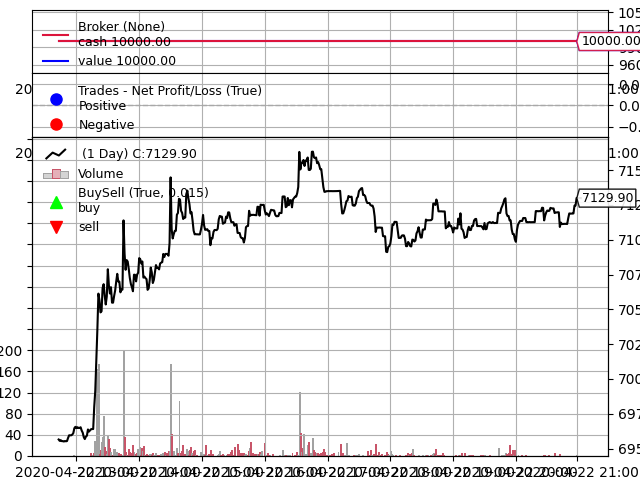

[[<Figure size 640x480 with 4 Axes>]]

In [30]:
cerebro.plot()